In [49]:
# importing libraries required for the project
!pip install pmdarima
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
from google.colab import files
from scipy.stats import mannwhitneyu
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import io
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 9.8 MB 51.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [50]:
# Loading the files (first and second dataset)
main_df_1 = pd.read_csv('Covid19-vaccination.csv')
main_df_2 = pd.read_csv('Complete_covid19_dataset.csv')
df = main_df_1.copy()
complete_df = main_df_2.copy()
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


In [51]:
# checking the shape of the dataset
df.shape

(63006, 16)

In [52]:
# feature names
feat_names = df.columns
print (feat_names)

Index(['location', 'iso_code', 'date', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'daily_vaccinations_raw', 'daily_vaccinations',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'daily_vaccinations_per_million', 'daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred'],
      dtype='object')


In [53]:
# Checking Total number of unique countries
country_names= df['location'].unique()
print(f'Total Number of countries in the dataset is {len(country_names)}')

Total Number of countries in the dataset is 235


In [54]:
# checking the distribution of the countries in the dataset
df['location'].value_counts().sort_values(ascending=True)

Burundi              31
Niue                 43
Falkland Islands     67
Tanzania             83
Pitcairn             85
                   ... 
Denmark             356
Europe              356
World               356
High income         356
European Union      356
Name: location, Length: 235, dtype: int64

# Part 1: Data Cleaning 

In [55]:
# checking for missing values in covid-19 dataset 
features = df.isna().sum().index
miss_val = df.isna().sum().values
missing_values = {'features':features,'missing_values':miss_val}
value = pd.DataFrame(missing_values)
value.style.hide_index()

features,missing_values
location,0
iso_code,0
date,0
total_vaccinations,27277
people_vaccinated,28883
people_fully_vaccinated,31853
total_boosters,56393
daily_vaccinations_raw,33083
daily_vaccinations,326
total_vaccinations_per_hundred,27277


Observation: We can see that there are 27277 number of rows which are NaN values for total vaccinations, since we wont be getting any insight without knowing total vaccination, those rows are dropped.

In [56]:
# dropping rows which have nan values 
df = df.drop(df[df.total_vaccinations.isna()].index)

In [58]:
# Checking the missing values after dropping

features = df.isna().sum().index
miss_val = df.isna().sum().values
missing_values = {'features':features,'missing_values':miss_val}
value = pd.DataFrame(missing_values)
value.style.hide_index()

features,missing_values
location,0
iso_code,0
date,0
total_vaccinations,0
people_vaccinated,1879
people_fully_vaccinated,4751
total_boosters,29169
daily_vaccinations_raw,5806
daily_vaccinations,235
total_vaccinations_per_hundred,0


In [59]:
# Checking the distribution of the countries
df['location'].value_counts().sort_values(ascending=True)

Turkmenistan                         2
Bonaire Sint Eustatius and Saba      2
Tokelau                              4
Niue                                 4
Pitcairn                             5
                                  ... 
European Union                     345
Norway                             351
Europe                             356
World                              356
High income                        356
Name: location, Length: 235, dtype: int64

In [60]:
# Checking for the entires which are lesser than 20.
j=0
countries_list = []
count_val = []
for i in df['location'].value_counts():
  if i <=20:
    countries_list.append(df['location'].value_counts().index[j])
    count_val.append(i)
  j+=1
    

In [61]:
# Values which has lesser than 20 entries in the cleaned dataset

countries_less_entry = {'Country':countries_list,'Entries':count_val}
pd.DataFrame(countries_less_entry).style.hide_index()


Country,Entries
Togo,20
Vanuatu,20
Bosnia and Herzegovina,19
Venezuela,19
Liberia,19
Myanmar,19
Central African Republic,18
Guinea-Bissau,18
Solomon Islands,17
Niger,17


Observation: Since the values of certain countries are very low, it will be really difficult to predict the values for the countries with values such as 2,4,5 etc.,

Correlation Plot:

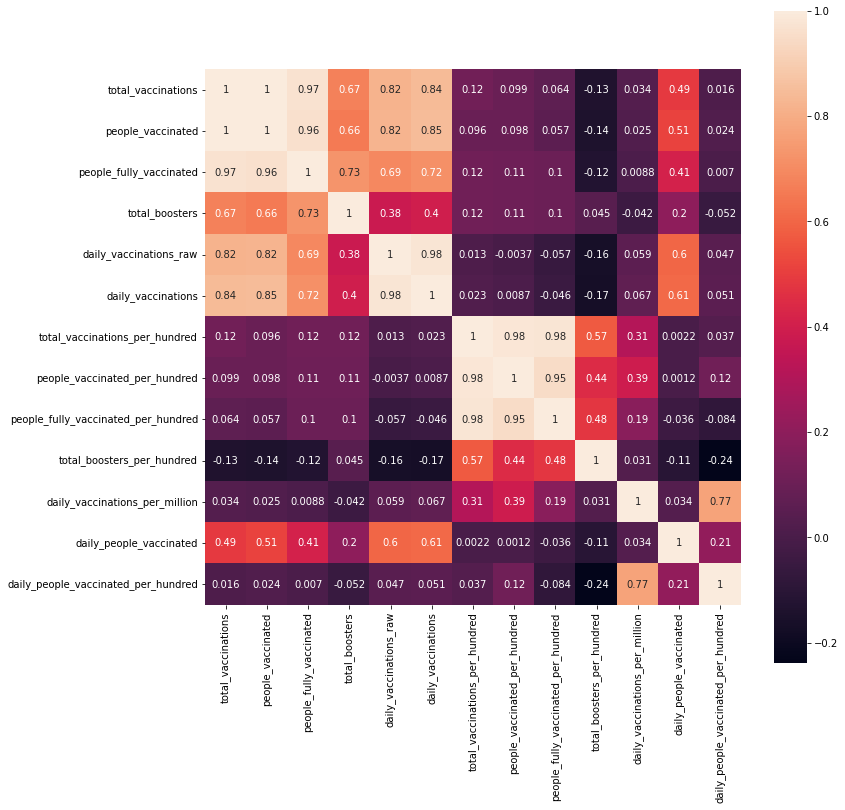

In [62]:
# Correlation plot for the features

plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

Observation: It can be seen that total vaccinations and people vaccinated are completely correlated (correlation = 1) and people fully vaccinated is also highly positively correlated with total vaccinations and people vaccinated(one dose). similarly, in terms of hunderds as well, total vaccinations, one dose vaccination and completely vaccinated columns are completely positively correlated with each other.

In [63]:
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

Checking the distribution of two features is same or not using non parametric statistical hyposthesis testing 

Assumptions: 

* Observations in each sample are independent and identically distributed (iid).
* Observations in each sample can be ranked.

Interpretation

* H0: the distributions of both samples are equal.
* H1: the distributions of both samples are not equal.

In [64]:
# Checking for people fully vaccinated with total vaccinations

res = mannwhitneyu(df['people_fully_vaccinated'], df['total_vaccinations'])
print(res)


MannwhitneyuResult(statistic=632067285.5, pvalue=0.012111294473493106)


Since p value is lesser than 0.05 we are rejecting the null hypothesis. The ranksums are different for both features.

In [65]:
# Since the countries are already mentioned in the dataframe, common clubbing names are removed
names = ['Asia','European Union','High income','Low income','Lower middle income','Upper middle income','World','Europe','North America','South America','United Kingdom']

In [66]:
# Dropping the common clubbed categories
df = df.drop(df[df.location.isin(names)].index)

In [67]:
# Number of countries after dropping common countries names
len(df.location.unique())

224

In [68]:
# checking distributions for people fully vaccinated and total vaccinations
res = mannwhitneyu(df['people_fully_vaccinated'], df['total_vaccinations'],alternative='two-sided')
print(res)

MannwhitneyuResult(statistic=506783180.0, pvalue=0.0011040556420373962)


In [69]:
# Checking distributions for people vaccinated (one dose) with total vaccinations
res = mannwhitneyu(df['people_vaccinated'], df['total_vaccinations'],alternative='two-sided')
print(res)

MannwhitneyuResult(statistic=496314995.5, pvalue=1.109344906927695e-14)


In [70]:
# Checking distributions for total vaccinations per hundred with people vaccinated per hundred (one dose) since they are highly correlated
res = mannwhitneyu(df['people_vaccinated_per_hundred'], df['total_vaccinations_per_hundred'],alternative='two-sided')
print(res)

MannwhitneyuResult(statistic=444939952.0, pvalue=5.853360271008397e-193)


In [71]:
# Checking the distributions similarity for people fully vaccinated per hundred and total vaccinations per hundred
res = mannwhitneyu(df['people_fully_vaccinated_per_hundred'], df['total_vaccinations_per_hundred'],alternative='two-sided')
print(res)

MannwhitneyuResult(statistic=451315171.5, pvalue=1.533434772153756e-159)


In [72]:
# Checking the distributions similarity for daily vaccinations and daily vaccinations raw
res = mannwhitneyu(df['daily_vaccinations'], df['daily_vaccinations_raw'],alternative='two-sided')
print(res)

MannwhitneyuResult(statistic=406350534.5, pvalue=0.0)


Observations:

From cheking the distributions simlarity for the highly correlated features to impute, it is seen that their distributions are different. Therefore all the missing values are imputed with zero for further discussion and analysis.

In [76]:
# imputing all the missing values with zero as the distributions are different

df.people_vaccinated.fillna(0, inplace = True)
df.people_fully_vaccinated.fillna(0, inplace = True)
df.total_boosters.fillna(0, inplace = True)
df.daily_vaccinations_raw.fillna(0, inplace = True)
df.daily_vaccinations.fillna(0, inplace = True)
df.people_vaccinated_per_hundred.fillna(0, inplace = True)
df.people_fully_vaccinated_per_hundred.fillna(0, inplace = True)
df.total_boosters_per_hundred.fillna(0,inplace = True)
df.daily_vaccinations_per_million.fillna(0, inplace = True)
df.daily_people_vaccinated.fillna(0,inplace=True)  
df.daily_people_vaccinated_per_hundred.fillna(0,inplace=True) 

In [77]:
# checking for missing values
df.isna().sum()

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

# Part 2: Data visualization and Exploratory Data Analysis

In [82]:
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,0.0,0.0,0.0,1367.0,0.02,0.02,0.0,0.0,34.0,1367.0,0.003
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,0.0,0.0,0.0,2862.0,0.14,0.14,0.0,0.0,72.0,2862.0,0.007
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,0.0,0.0,0.0,3000.0,0.30,0.30,0.0,0.0,75.0,3000.0,0.008
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,0.0,0.0,0.0,8000.0,0.60,0.60,0.0,0.0,201.0,8000.0,0.020


Observation: From the dataset, it can be seen that,
* Total vaccinations, people vaccinated (single dose) and people fully vaccinated are cumulative for each country. Therefore as the date progresses, the value of the columns keep increasing. 
* Total Boosters administered is also cumulative for each country seperately, which represents the amount of booster vaccines adminisitered, whereas boosters/hundred is also cumulative it represents the rate at which the vaccines are administered.
* Daily vaccinations column represents the quantity of vaccines adminisited for that day for each country separately.
* Daily people vaccinated represents the total vaccines administered to the people on that day for each country in total population and daily vaccinated per hundred represents the rate at which the vaccines are administered 

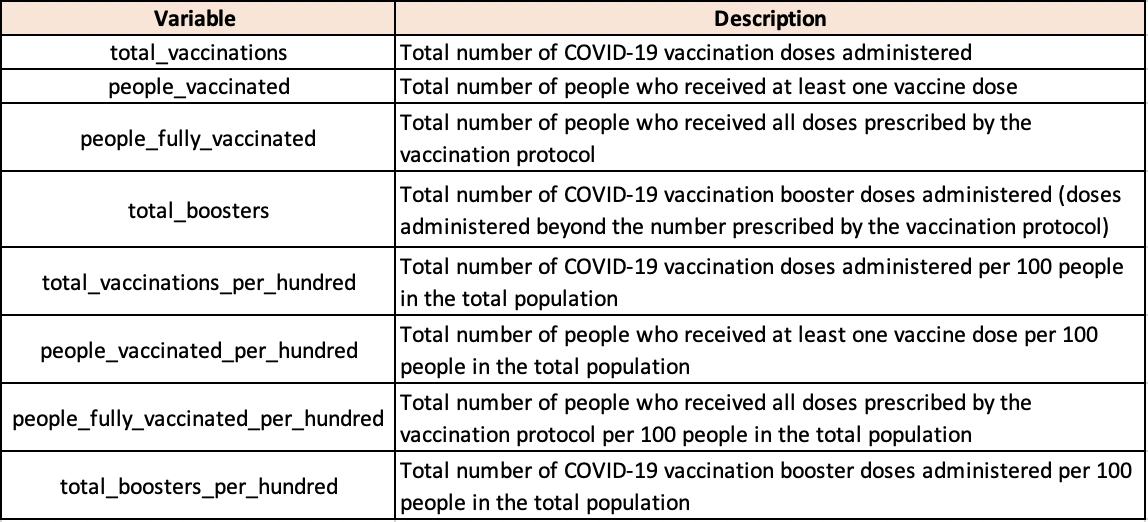

plot 1: Lets take a look at the best performing countries in regards to total vaccination and the vaccination rates with respect to the population of the country.

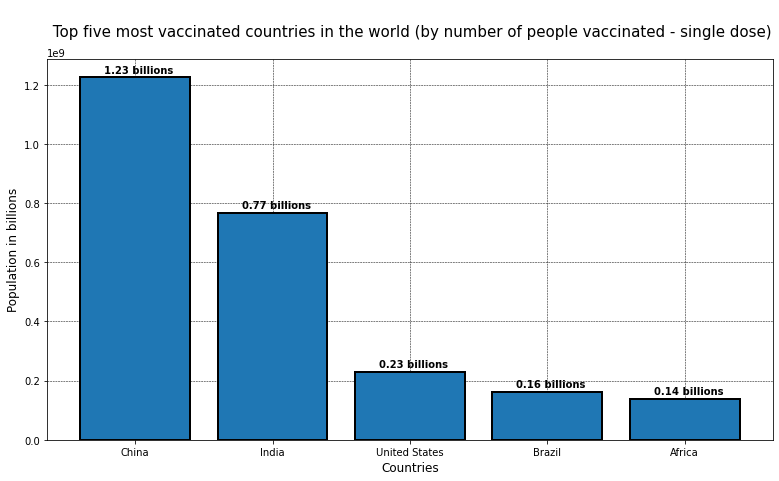

In [83]:
top_total_vaccinations = df.groupby('location').people_vaccinated.max().sort_values(ascending=False)
# display(pd.DataFrame(top_total_vaccinations[0:5]).reset_index())
# plotting bar plot
plt.figure(figsize=(13, 7))
plt.title('\n Top five most vaccinated countries in the world (by number of people vaccinated - single dose)\n',size=15)
bar = plt.bar(list(top_total_vaccinations.index[0:5]),list(top_total_vaccinations[0:5]),edgecolor='k',linewidth=2,zorder=4)
for bar in bar:
  values = bar.get_height()
  plt.text(bar.get_x()+0.175, values + 15550000,f'{round((values/1000000000),2)} billions', weight='bold', fontsize=10, color='k') 
plt.xlabel('Countries',size=12)
plt.ylabel('Population in billions',size=12)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

Observation: From the graph it can be seen that china has totally administered 1.23 billion vaccines whereas rest of the countries are still lagging behind. India has administered 0.77 billion vaccines to its population, but, based on the total population for china and india, the vaccination given to the population might not have been at a good pace compared to other countries. US has administered 230 million vaccines but inorder to know the actual rate of vaccine administration with respect to population of the country, total vaccinations per hundred feature should be used.

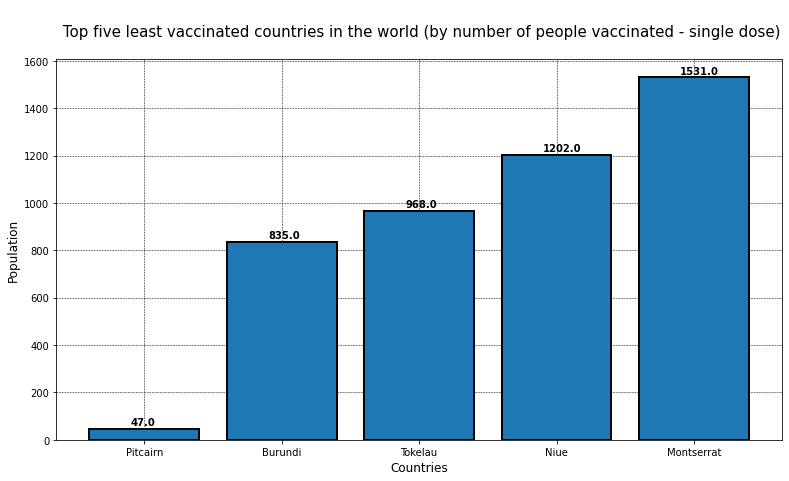

In [84]:
# plot 2: lets take a look at top 5 least vaccinated countries in the world

top_total_vaccinations = df.groupby('location').people_vaccinated.max().sort_values(ascending=True)
# display(pd.DataFrame(top_total_vaccinations[0:5]).reset_index())
# plotting bar plot
plt.figure(figsize=(13, 7))
plt.title('\n Top five least vaccinated countries in the world (by number of people vaccinated - single dose)\n',size=15)
bar = plt.bar(list(top_total_vaccinations.index[0:5]),list(top_total_vaccinations[0:5]),edgecolor='k',linewidth=2,zorder=4)
for bar in bar:
  values = bar.get_height()
  plt.text(bar.get_x()+0.3, values+15,values, weight='bold', fontsize=10, color='k') 
plt.xlabel('Countries',size=12)
plt.ylabel('Population',size=12)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

Observation: Though the number of least vaccinations seems very low, 4 cases in the plot are less due to the lesser population in the island / territory. however, Burundi country has population of approx 11.5 million population they have administered only 835 doses of vaccine. This may be because of the financial situation of the country.

plot 3: Effective Vaccination program:

The effeectiveness of the vaccination program is analysed using the population of each country as a benchmark: how many people each country has administered vaccine with respect to their population. 

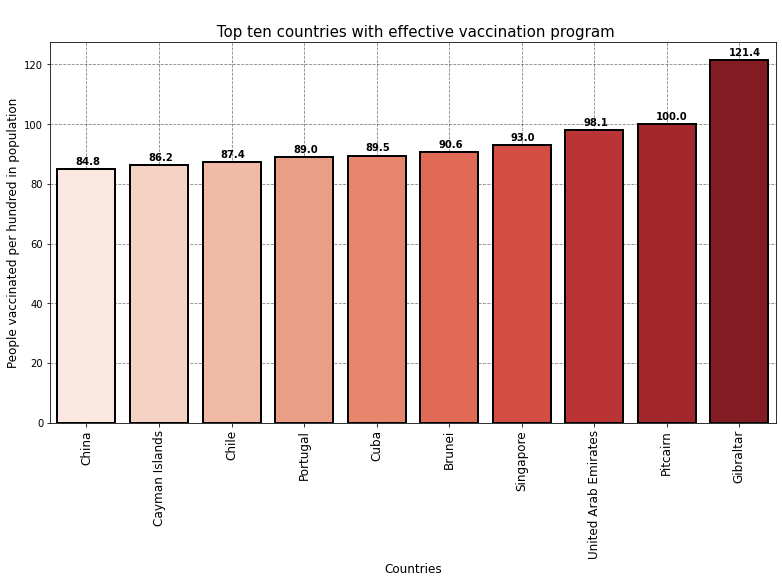

In [85]:
top_total_vaccinations = df.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending=False)
data = pd.DataFrame(top_total_vaccinations).reset_index()[0:10]
data = data.sort_values(by=['people_vaccinated_per_hundred'])
plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries with effective vaccination program',size=15)
#bar = plt.bar(list(top_total_vaccinations.index[0:10]),list(top_total_vaccinations[0:10]),edgecolor='k',linewidth=2,zorder=4,)
bar = sns.barplot(x='location', y='people_vaccinated_per_hundred',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Reds')
for i, val in enumerate(data['people_vaccinated_per_hundred']):
    plt.text(i-0.15, val+1.5, f'{np.round(val, 1)}', weight='bold', fontsize=10, color='k')
# for bar in bar:
#   values = bar.get_height()
#   plt.text(bar.get_x()+0.15, values+1.5,values, weight='bold', fontsize=10, color='k') 
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('People vaccinated per hundred in population',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observaiton: From the graph it can be seen that Gibraltar country data is skewed, as there cannot be more than 100 in vaccine administered for 100 people from their total population. Therefore, lets drop Gibraltar country and Pitcaim as well since the island has very less population, it has been administered to the entire population. 

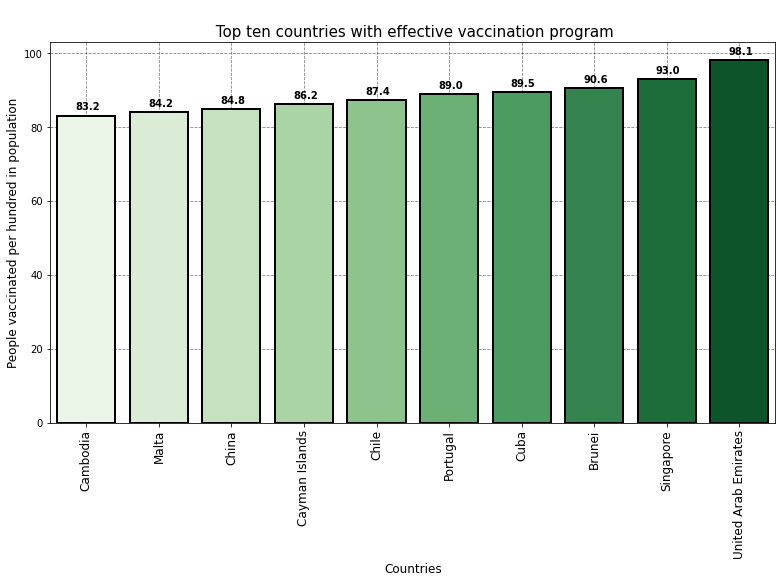

In [86]:
# Plot 4: Top 10 effective vaccination program after cleaning

top_total_vaccinations = df.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending=False)
data = pd.DataFrame(top_total_vaccinations).reset_index()
todrop = ['Gibraltar','Pitcairn']
data = data.drop(data[data.location.isin(todrop)].index)
data = data[0:10]
data = data.sort_values(by=['people_vaccinated_per_hundred'])

plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries with effective vaccination program',size=15)
bar = sns.barplot(x='location', y='people_vaccinated_per_hundred',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Greens')
for i, val in enumerate(data['people_vaccinated_per_hundred']):
    plt.text(i-0.15, val+1.5, f'{np.round(val, 1)}', weight='bold', fontsize=10, color='k')
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('People vaccinated per hundred in population',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: From the Plot we can see that UAE, Singapore and few other countries have effective vaccination program and was able to administer vaccines effectively. Also, it is interesting to see that China with huge population was also able to administer vaccines effectively.

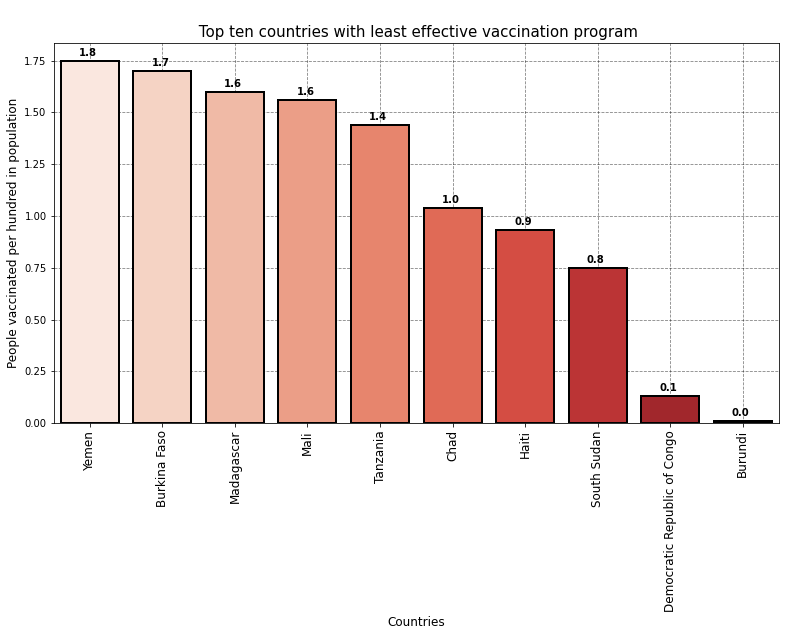

In [87]:
# plot 5: Least effective vaccination program

top_total_vaccinations = df.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending=True)
data = pd.DataFrame(top_total_vaccinations).reset_index()[0:10]
data = data.sort_values(by=['people_vaccinated_per_hundred'],ascending=False)
plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries with least effective vaccination program',size=15)
bar = sns.barplot(x='location', y='people_vaccinated_per_hundred',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Reds')
for i, val in enumerate(data['people_vaccinated_per_hundred']):
    plt.text(i-0.15, val+0.025, f'{np.round(val, 1)}', weight='bold', fontsize=10, color='k')
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('People vaccinated per hundred in population',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: As previously least vaccinated country plot - Figure 2 in EDA, Burundi, eventhough the population is more, the number of vaccines administered is very low. Therefore, the vaccination rate is also very close to zero. Another Important fact to note in this plot is that, all the countries are low income countries, therefore its natural to believe that the cost for affording vaccine might be difficult.

link to the list of low income countries is provided below,

https://g2lm-lic.iza.org/call-phase-iv/list-of-lic/

Plot 6: Now lets take a look at maximum number of vaccination administered by a country in a single date to check the effectiveness of the logistics and performance against COVID-19. This can also let us derive insight about the awareness of the puplic against covid-19

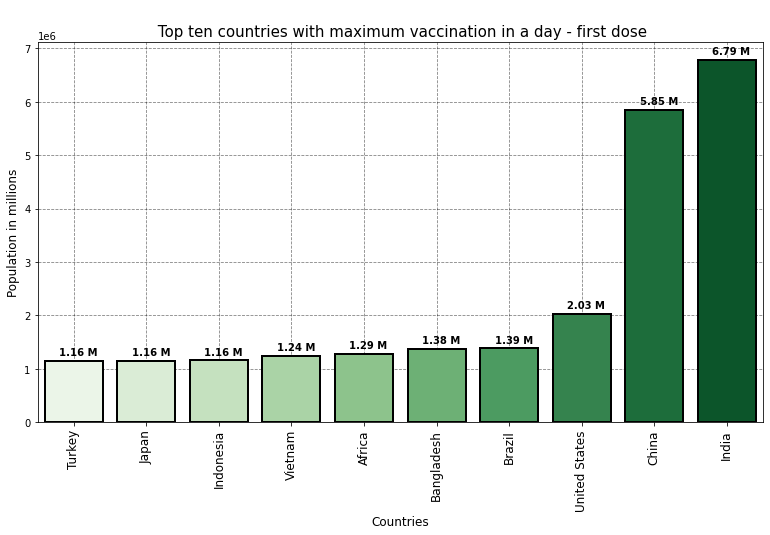

In [88]:
# checking the maximum vaccinations done by a country in a single day to check the effectiveness of a government. [first dose alone]
top_total_vaccinations = df.groupby('location').daily_people_vaccinated.max().sort_values(ascending=False)
data = pd.DataFrame(top_total_vaccinations).reset_index()[0:10]
data = data.sort_values(by=['daily_people_vaccinated'])
plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries with maximum vaccination in a day - first dose',size=15)
bar = sns.barplot(x='location', y='daily_people_vaccinated',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Greens')
for i, val in enumerate(data['daily_people_vaccinated']):
    plt.text(i-0.2, val+100000, f'{np.round((val/1000000), 2)} M', weight='bold', fontsize=10, color='k')
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('Population in millions',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

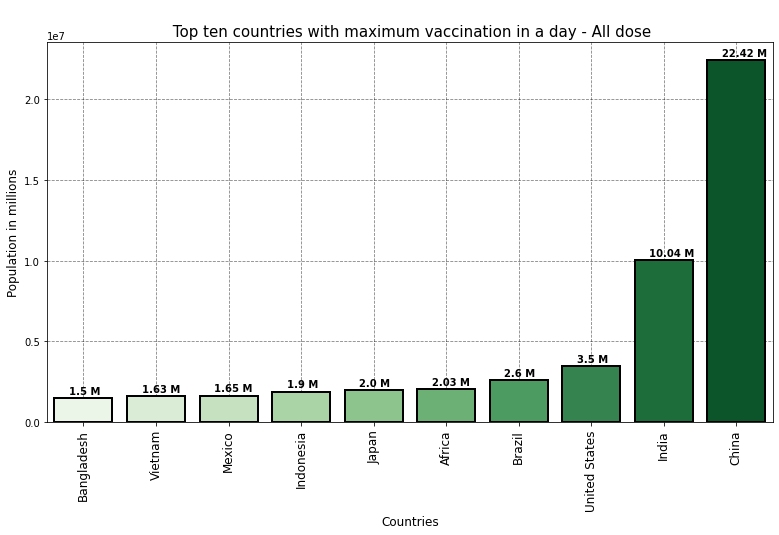

In [89]:
#plot7: checking the maximum vaccinations done by a country in a single day to check the effectiveness of a government.[all the doses together]

top_total_vaccinations = df.groupby('location').daily_vaccinations.max().sort_values(ascending=False)
data = pd.DataFrame(top_total_vaccinations).reset_index()[0:10]
data = data.sort_values(by=['daily_vaccinations'])
plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries with maximum vaccination in a day - All dose',size=15)
bar = sns.barplot(x='location', y='daily_vaccinations',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Greens')
for i, val in enumerate(data['daily_vaccinations']):
    plt.text(i-0.2, val+250000, f'{np.round((val/1000000), 2)} M', weight='bold', fontsize=10, color='k')
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('Population in millions',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()


Observation: From the graph we can observe that, India and china has administered the maximum number of vaccines in a day. This should be mainly because of the population density in both the countries. However, the value of max total vaccination is approximately a million high than China for single dose vaccination head count, this might because of the unsteady vaccination in India. As we can see from the figure 4 in EDA, China is administrating vaccines at an effective rate, however its not that effective in India.

Overall, considering first, second and booster vaccine, China has administered 22.42 Million doses per day and India has administered 10.04 Million dosses and remaining countries from 1.5 - 3.5 M range in top 10 countries.

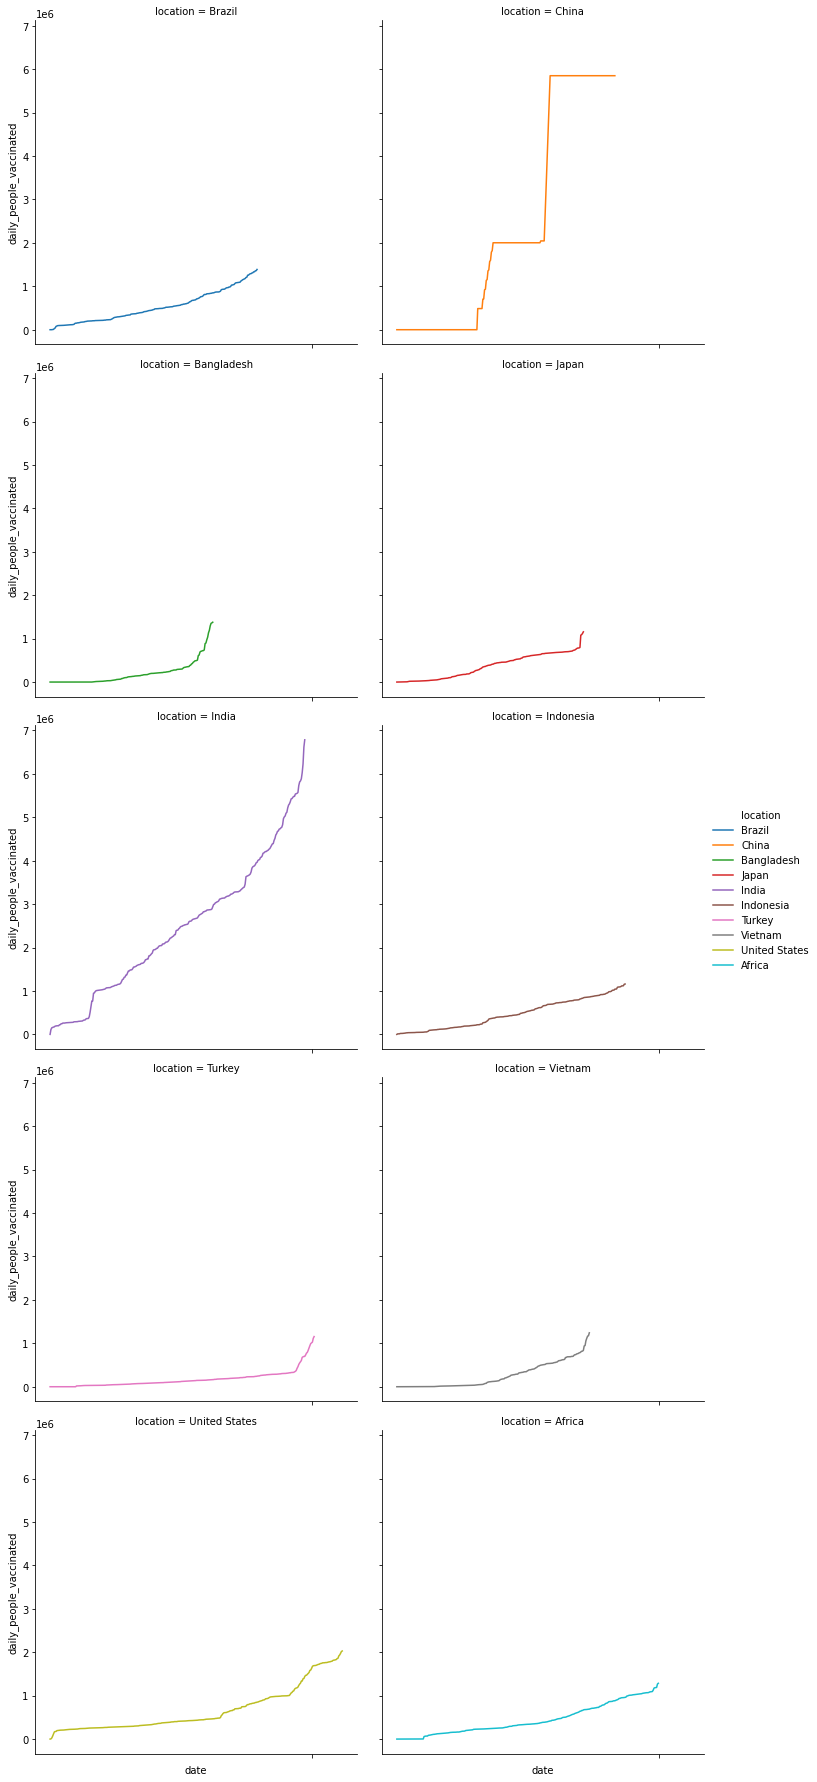

In [91]:
# plot 8: country wise and day wise trend - Vaccination status

# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'daily_people_vaccinated']
covid_df = df.reset_index()

# Creating a list of the aforementioned best performing countries in terms of daily vaccinations (Maximum count)
top_10_countries = [
    'China',
    'United States',
    'India',
    'Bangladesh',
    'Brazil',
    'Africa',
    'Vietnam',
    'Indonesia',
    'Japan',
    'Turkey'
]

# Filtering and sorting the data
daily_vacc_df = covid_df[['location', 'date', 'daily_people_vaccinated']].sort_values(by='daily_people_vaccinated', ascending=True)
top_10_dv_df = daily_vacc_df[daily_vacc_df.location.isin(top_10_countries)].dropna()
sns.relplot(data=top_10_dv_df, x='date', y='daily_people_vaccinated', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('');

Observation: It can be seen that there is an exponential increase in the number of vaccinations in China compared to other countries. India as well has an exponential increase towards the end. Other countries also are increasing the number of vaccination per day for people as time progresses and this may also be attributable to the iterative approach of operations efficiency for distribution and administration of vaccination to the masses.

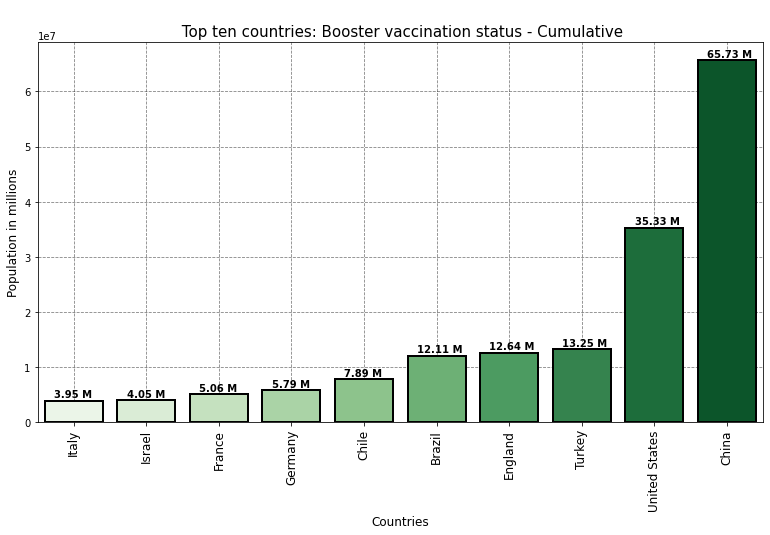

In [92]:
#plot 9: Lets check the booster vaccination status for different countries

top_total_vaccinations = df.groupby('location').total_boosters.max().sort_values(ascending=False)
data = pd.DataFrame(top_total_vaccinations).reset_index()[0:10]
data = data.sort_values(by=['total_boosters'])
plt.figure(figsize=(13, 7))
plt.title('\n Top ten countries: Booster vaccination status - Cumulative',size=15)
bar = sns.barplot(x='location', y='total_boosters',  data=data, edgecolor='k', linewidth=2, zorder=4,palette='Greens')
for i, val in enumerate(data['total_boosters']):
    plt.text(i-0.27, val+550000, f'{np.round((val/1000000), 2)} M', weight='bold', fontsize=10, color='k')
plt.xlabel('Countries',size=12)
plt.xticks(fontsize = 12,rotation=90)
plt.ylabel('Population in millions',size=12)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: Except China, Brazil, and Turkey all the other countries in the top 10 consumer of booster vaccinations are high income countries. this is representative of wealth of the country.  

# Part 3: Model selection and fitting to data

In [93]:
# Modelling needs to be done for two countries: Selecting Canada and United states 

canada_df = df[df['location']=='Canada']
val = canada_df['total_vaccinations'].values
dates_canada = list(canada_df['date'])

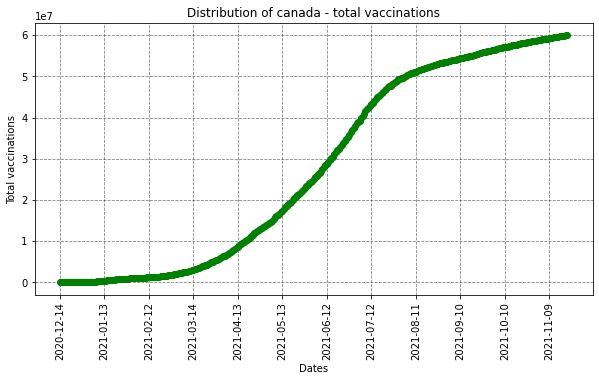

In [94]:
# Distribution of vaccination
plt.figure(figsize=(10, 5))
plt.plot(canada_df['date'],canada_df['total_vaccinations'],'go-', linewidth=1)
plt.title("Distribution of canada - total vaccinations")
plt.xlabel("Dates")
plt.ylabel("Total vaccinations")
ticks = np.arange(0,343,30)
labels = [dates_canada[i]for i in range (0,343,30)]
plt.xticks(ticks, labels,rotation = 90)
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: From the plot we can see that there doesnt seem to be any seasonality, but there is a trend, as the time progresses, total vaccinations per hundred also increases. From looking at the plot, we can also infer that dataset is not stationary as mean for various time period is different throughout the entire time period. 

For stationarity, mean and standard deviation should be constant throughout the timeperiod.

In [95]:
# Lets check the same with statistical test as well

X = canada_df.total_vaccinations.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.342180
p-value: 0.609661
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

Interpretation:

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Result Obtained:

p- value = 0.609 which is greater than 0.05, therefore, we fail to reject the null hypothesis, The dataset is non stationary.

MODEL SELECTION: 

ARIMA model is used for forecasting vaccination rate for two countries as it is one of the simple and most suited model for dataset with trend and without seasonality.

ARIMA Model combines both Autoregression (AR) and Moving Average (MA) models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I).

The ARIMA model has three parameters: 
* "P" is the autoregressive lags, 
* "Q" is the moving average, and 
* "d" is the order of differentiation.


<Figure size 936x504 with 0 Axes>

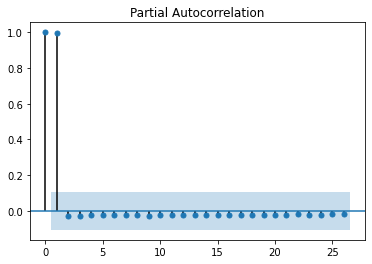

In [96]:
# checking p value using partial Auto correlation [autoregressive lags]
plt.figure(figsize=(13, 7))
plot_pacf(val)
plt.show()

Observation: From the plot it can be seen that, we were not able to get any meaningful insight / good correlation for prediciton after t-2 data, therefore p=2 can be choosen as per plot.

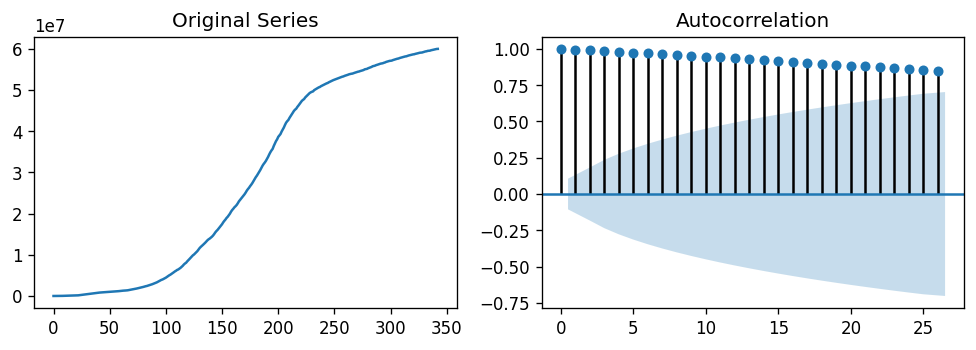

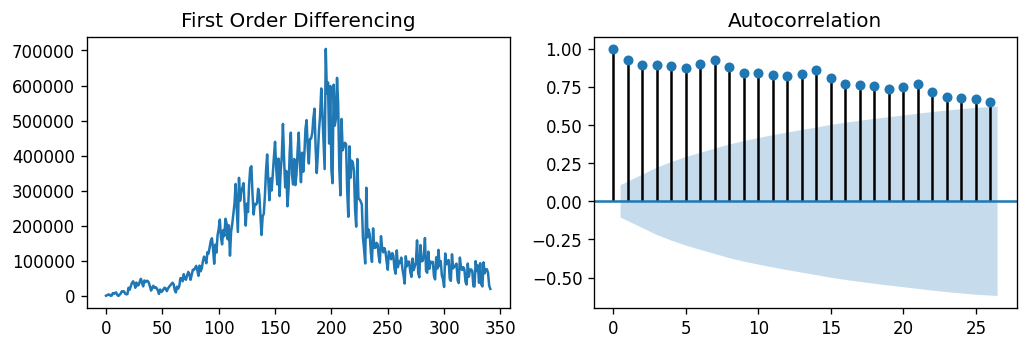

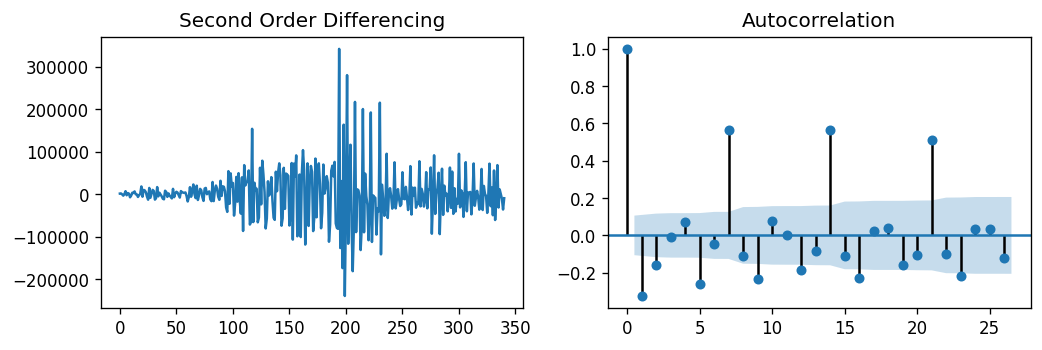

In [97]:
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
# Original Series
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(val); ax1.set_title('Original Series')
plot_acf(val, ax=ax2)
plt.show()

# performing first order Differencing
first_diff = np.diff(val)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(first_diff); ax1.set_title('First Order Differencing')
plot_acf(first_diff, ax=ax2)
plt.show()

# performing second order Differencing
second_diff = np.diff(first_diff)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(second_diff); ax1.set_title('Second Order Differencing')
plot_acf(second_diff, ax=ax2)
plt.show()

Observation: It can be seen that for second order differencing data, the data seems to be stationary. The same can be checked with statistical test also. q=3 seems to be a good option as per autocorrelation plot.

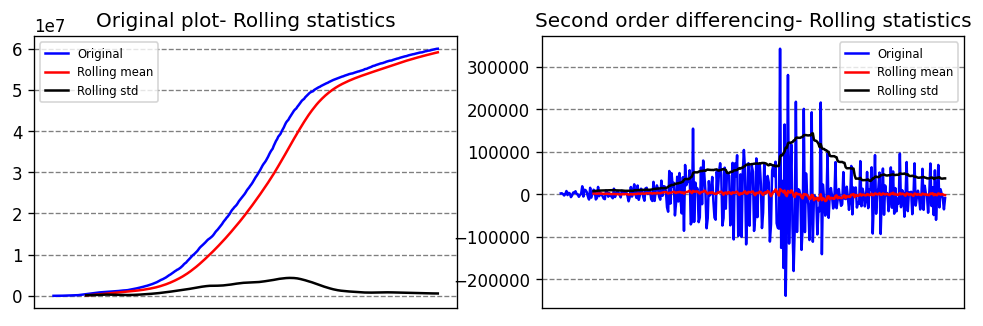

In [98]:
second_diff_df = pd.DataFrame(second_diff,columns=[['second_diff']])
rolmean = canada_df.total_vaccinations.rolling(window=30).mean()
rolstd = canada_df.total_vaccinations.rolling(window=30).std()
rolmean_sec = second_diff_df.rolling(window=30).mean()
rolstd_sec = second_diff_df.rolling(window=30).std()

fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(canada_df['total_vaccinations'],color = 'blue',label='Original')
ax1.plot(rolmean,color = 'red',label='Rolling mean')
ax1.plot(rolstd,color= 'black', label='Rolling std')
ax1.legend(loc='best',prop={"size":7})
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('Original plot- Rolling statistics')
ax1.grid(alpha=0.5, color='k', linestyle='--')

ax2.plot(second_diff_df,color = 'blue',label='Original')
ax2.plot(rolmean_sec,color = 'red',label='Rolling mean')
ax2.plot(rolstd_sec,color= 'black', label='Rolling std')
ax2.legend(loc='best',prop={"size":7})
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.title.set_text('Second order differencing- Rolling statistics')
ax2.grid(alpha=0.5, color='k', linestyle='--')


Observation: From the plots it can be seen that mean and standard deviation is almost same throughout, therefore we can infer that second order seems to be stationary.

In [99]:
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', max_p=2, max_q=3, # maximum p and q set to 3 based on the plots
m=1, # frequency of series
d=None, # letting model determine 'd'
seasonal=False, # No Seasonality as determined by plots
start_P=0,D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
#print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8372.490, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=8472.285, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=8436.253, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8377.853, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8470.292, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8368.978, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8407.222, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=8342.619, Time=0.51 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8370.777, Time=0.27 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=8324.232, Time=0.83 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=8354.599, Time=0.43 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=8322.255, Time=0.77 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=8351.738, Time=0.37 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=8336.749, Time=0.40 sec
 ARIMA(1,2,2)(0,0,0)[0]          

Observation: from the grid search result, it can be seen that best model is obtained for p=3, d=2 and q=3. d and q value as 2 and 3 can be infered from graphs plotted above but p=3 might have provided better result, but 

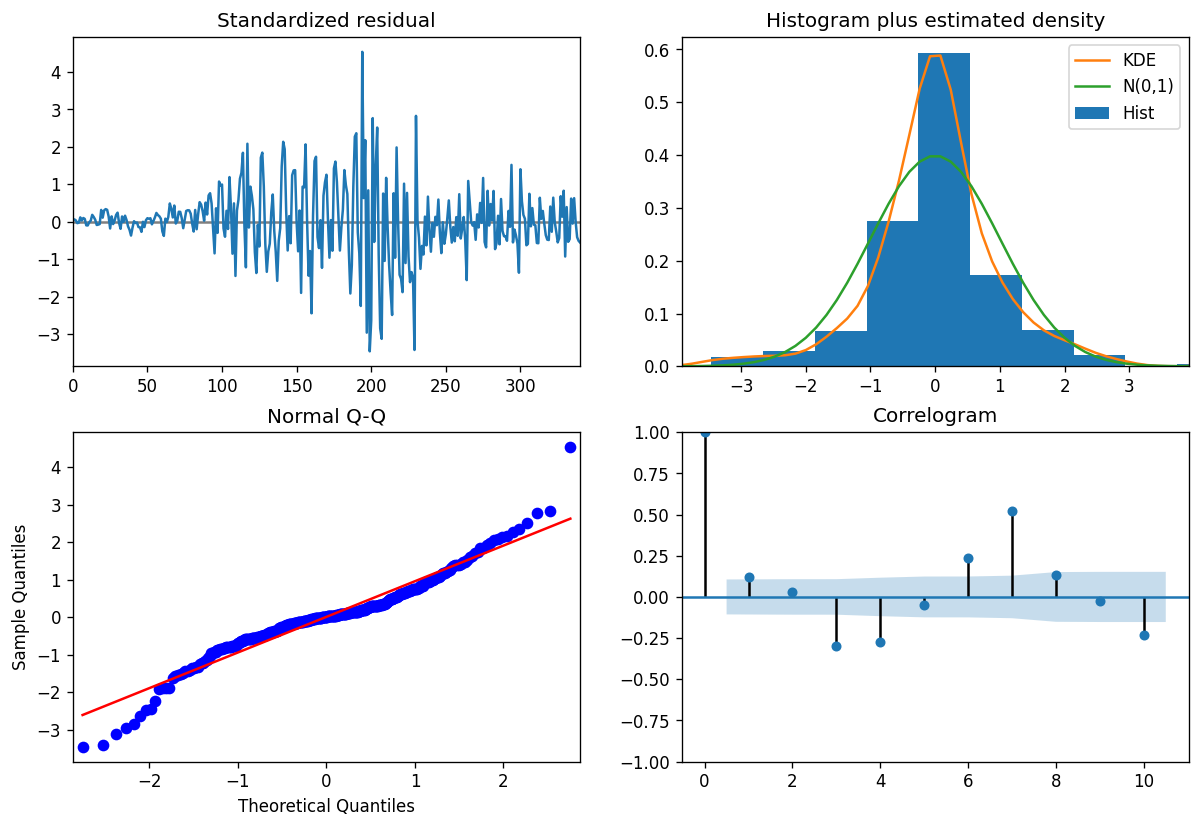

In [100]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

* Standardized residual: There are no obvious pattern in the standard residuals. (which represents the mean is same throughout the time)
* Histogram plus kde estimate: Kernal density estimators are nearly following the distribution of the data i.e.,Histogram. Therefore model can predict properly.
* Normal Q-Q plot: Theoritical quantities and sample quantities lie in the same line, which implies that samples follows the population distribution. 
* Correlation plot: The current data is uncorrelated with lagged version of itself.



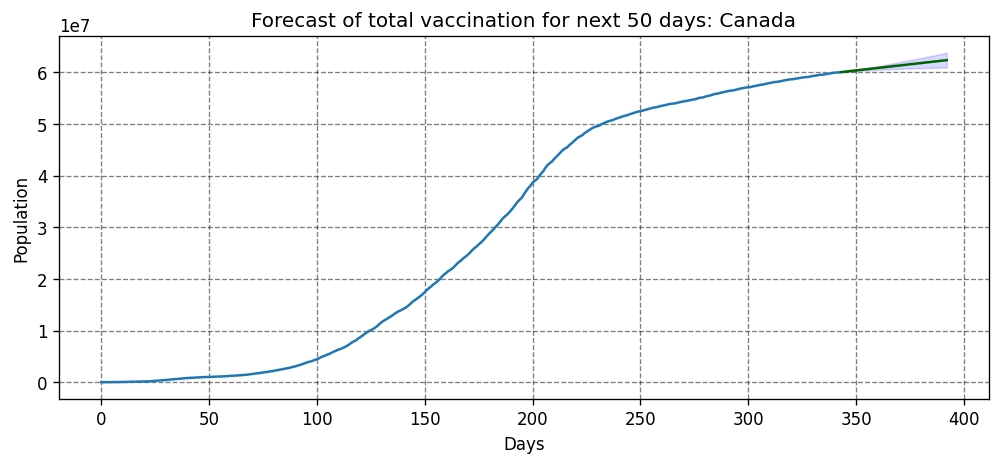

In [101]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.70)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,lower_series,upper_series,color='b', alpha=.15)
plt.title("Forecast of total vaccination for next 50 days: Canada")
plt.xlabel("Days")
plt.ylabel("Population")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

In [102]:
print(f'Best Case scenario Vaccination forecast: {round((list(upper_series)[-1]/1000000),2)} millions')
print(f'Base Case scenario Vaccination forecast: {round((list(fc_series)[-1]/1000000),2)} millions')
print(f'Worst Case scenario Vaccination forecast: {round((list(lower_series)[-1]/1000000),2)} millions')

Best Case scenario Vaccination forecast: 63.77 millions
Base Case scenario Vaccination forecast: 62.34 millions
Worst Case scenario Vaccination forecast: 60.91 millions


Observation: Since the value of the prediciton is going lesser for the worst case senario for the next 50 days, confidence interval is changed. Also, the projection/forecast of the data is done using only one variable i.e., total vaccination.

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=7146.562, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7256.764, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=7227.771, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=7179.468, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=7173.366, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=7171.760, Time=0.09 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=7184.122, Time=0.25 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=7134.135, Time=0.71 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=7160.121, Time=0.30 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=7126.284, Time=0.76 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=7127.955, Time=0.76 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=7136.812, Time=1.19 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=7131.633, Time=1.08 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=7190.315, Time=0.19 sec
 ARIMA(4,2,4)(0,0,0)[0]          

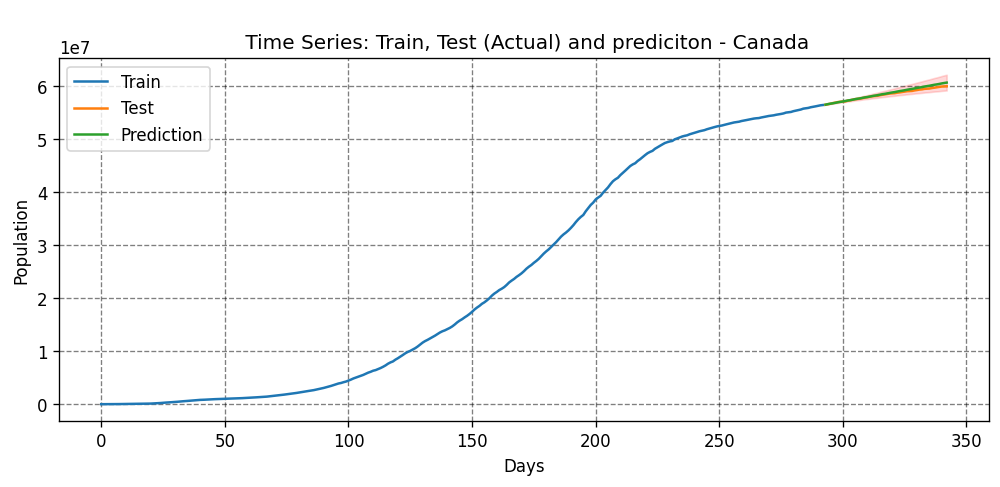

In [103]:
# Training the model using training data and testing the model with testing data
train = val[:293]
test = val[293:]
steps = 50 
model_canada = pm.auto_arima(train,trace=True,error_action='ignore', suppress_warnings=True)
model_canada.fit(train)
forecast,confint_ = model_canada.predict(n_periods=50,return_conf_int=True,alpha=0.70)
index_of_fc_ = np.arange(len(train), len(train)+steps)

forecast = pd.DataFrame(forecast,index = index_of_fc_,columns=['Prediction'])
test = pd.DataFrame(test,index = index_of_fc_)
lower_series = pd.Series(confint_[:, 0], index=index_of_fc_)
upper_series = pd.Series(confint_[:, 1], index=index_of_fc_)

plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='upper left')
plt.fill_between(lower_series.index,lower_series,upper_series,color='r', alpha=.15)
plt.title("\n Time Series: Train, Test (Actual) and prediciton - Canada")
plt.xlabel("Days")
plt.ylabel("Population")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: It can be seen that our actual values and predicted values are almost similar based on the model obtained from the training dataset. For the forecasting eventhough we have used p,d,q value as 2,2,3 the results seems to be similar for this case.

In [104]:
# THe same is done for United states:

us_df = df[df['location']=='United States']
val_us = us_df['total_vaccinations'].values
dates_us = list(us_df['date'])

<Figure size 1560x840 with 0 Axes>

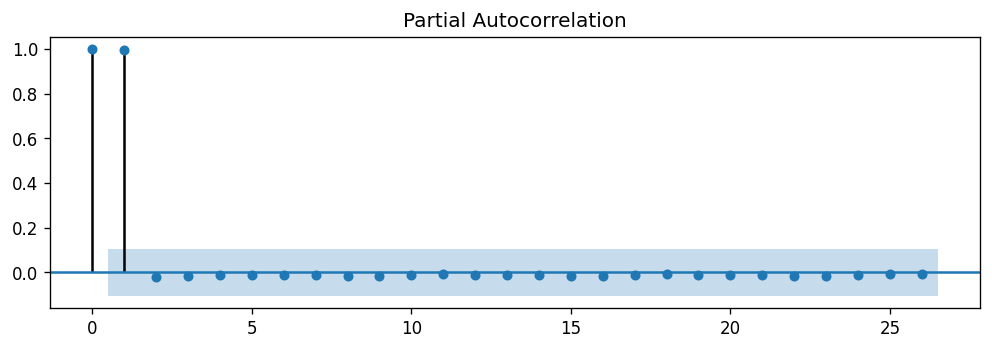

In [105]:
# Autocorrelation for US dataset
plt.figure(figsize=(13, 7))
plot_pacf(val_us)
plt.show()

Observation: From the graph it can be seen that the partial auto correlation for the US Dataset also is 2 and lags behind the time t-2 is not relevant.

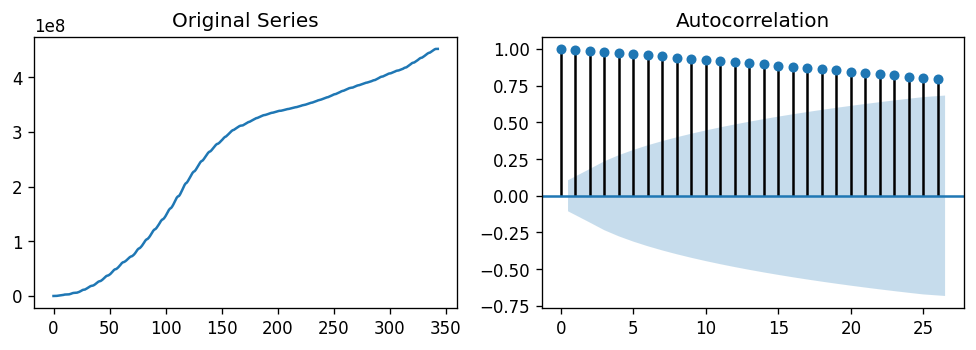

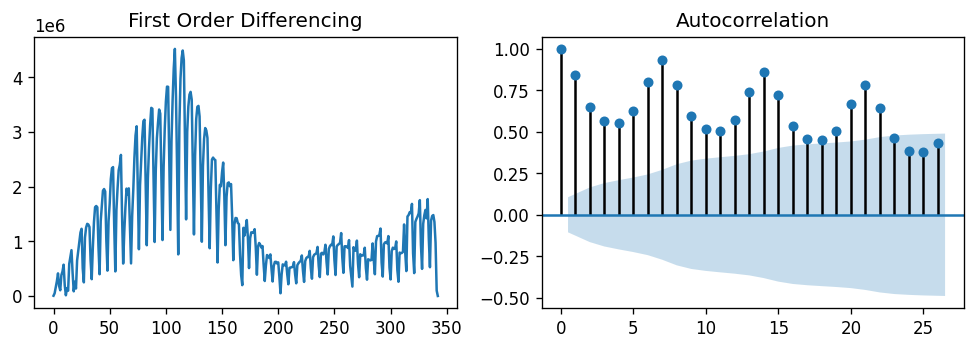

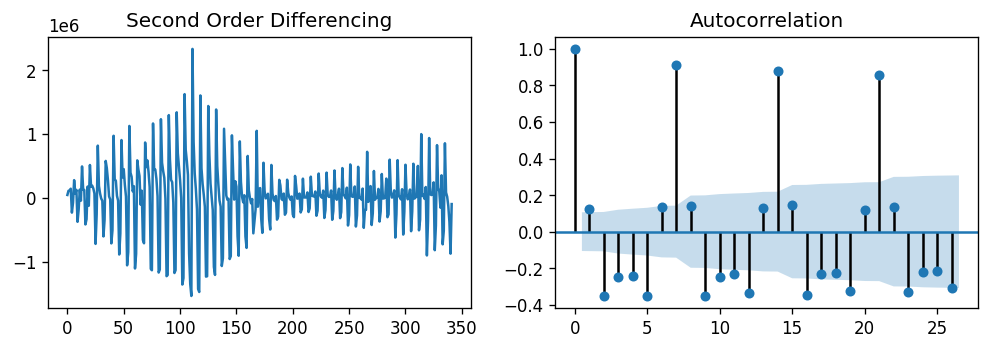

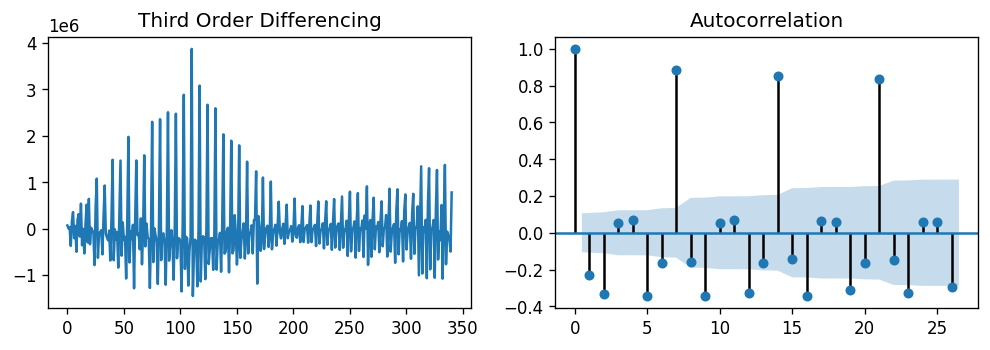

In [106]:
# plotting for US data
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
# Original Series
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(val_us); ax1.set_title('Original Series')
plot_acf(val_us, ax=ax2)
plt.show()

# performing first order Differencing
first_diff = np.diff(val_us)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(first_diff); ax1.set_title('First Order Differencing')
plot_acf(first_diff, ax=ax2)
plt.show()

# performing second order Differencing
second_diff = np.diff(first_diff)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(second_diff); ax1.set_title('Second Order Differencing')
plot_acf(second_diff, ax=ax2)
plt.show()

# performing third order Differencing
third_diff = np.diff(second_diff)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(third_diff); ax1.set_title('Third Order Differencing')
plot_acf(third_diff, ax=ax2)
plt.show()

Observation: It can be seen that second and third order differencing seems to be making the data stationary. however the same needs to be checked with statistical test. q=3 from third order differencing seems to be the best option.

In [107]:
model = pm.auto_arima(val_us, start_p=1, start_q=1,
test='adf', max_p=2, 
max_q=5, # maximum p and q set to 2 and 5 based on the plots
m=1, # frequency of series
d=None, # letting model determine 'd'
seasonal=False, # No Seasonality as determined by plots
start_P=0,D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
#print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9972.847, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=10006.617, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=10003.149, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9994.402, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10004.623, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9868.143, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9953.326, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=9823.811, Time=0.53 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=10041.469, Time=0.44 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=9835.269, Time=0.40 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=9888.173, Time=0.87 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=9818.225, Time=0.43 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9866.253, Time=0.14 sec
 ARIMA(2,2,3)(0,0,0)[0]           

Best model seems to be p=2,d=2 and q=2 for US dataset. The same is further analysed using the diagnostic plot.


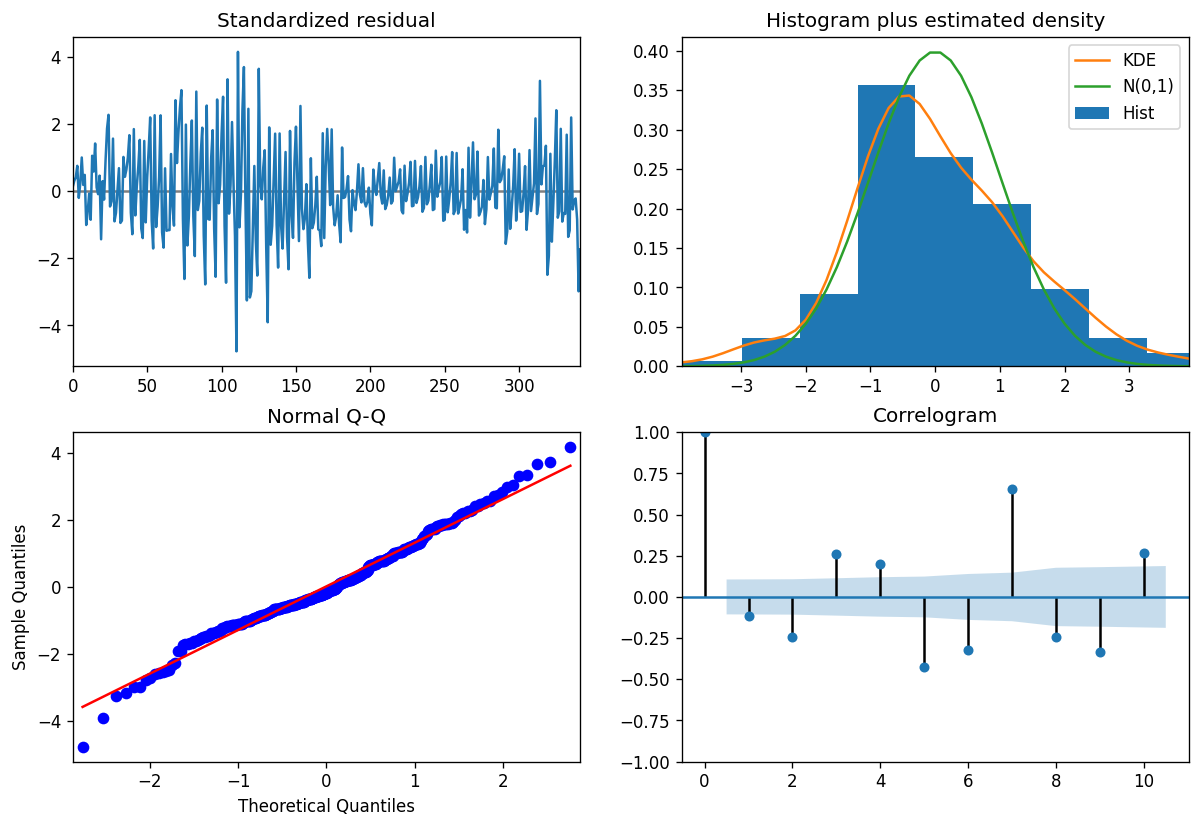

In [108]:
model.plot_diagnostics(figsize=(12,8))
plt.show()

Observaion: From the plots we can see that, there are no patterns in the second order diff data and density estimator seems to be following the distribution of the data. Also, as per quantile plot the sample quantities seems to be following the actual population distribution. The current data is not heavily correlated with the lagged values of itself.

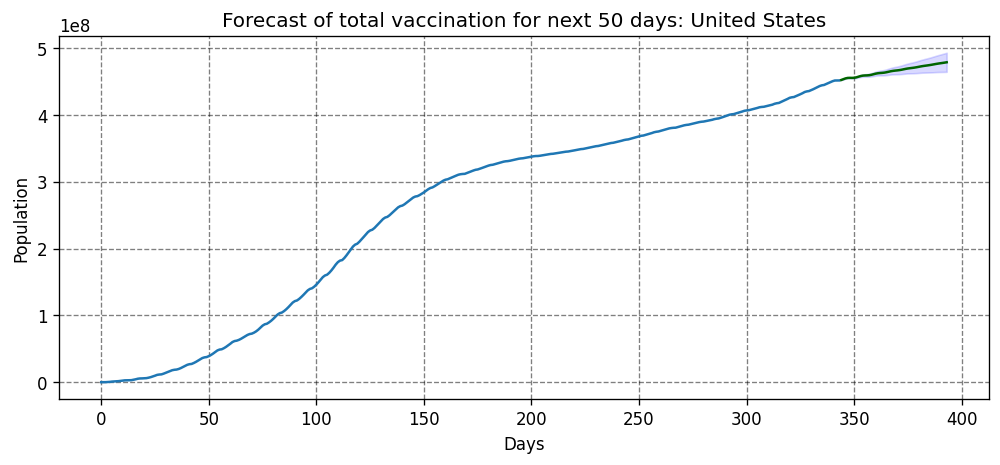

In [109]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.60)
index_of_fc = np.arange(len(val_us), len(val_us)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(val_us)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,lower_series,upper_series,color='b', alpha=.15)
plt.title("Forecast of total vaccination for next 50 days: United States")
plt.xlabel("Days")
plt.ylabel("Population")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

In [110]:
print(f'Best Case scenario Vaccination forecast: {round((list(upper_series)[-1]/1000000),2)} millions')
print(f'Base Case scenario Vaccination forecast: {round((list(fc_series)[-1]/1000000),2)} millions')
print(f'Worst Case scenario Vaccination forecast: {round((list(lower_series)[-1]/1000000),2)} millions')

Best Case scenario Vaccination forecast: 492.91 millions
Base Case scenario Vaccination forecast: 478.63 millions
Worst Case scenario Vaccination forecast: 464.36 millions


Observation: It can be seen that with alpha value of 0.60, the values of prediciton for all three cases are provided above. Unlike canada, US dataset didnt have much correlation using the auto correlation plot (q=3 for cananda, whereas q=2 for US)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=8387.444, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8559.651, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=8555.483, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=8546.630, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=8617.569, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=8436.686, Time=0.09 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=8556.998, Time=0.34 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=8412.324, Time=0.33 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=8531.971, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=8456.051, Time=0.41 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=8431.788, Time=0.25 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=8407.488, Time=0.56 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=8392.578, Time=0.47 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 3.327 seconds


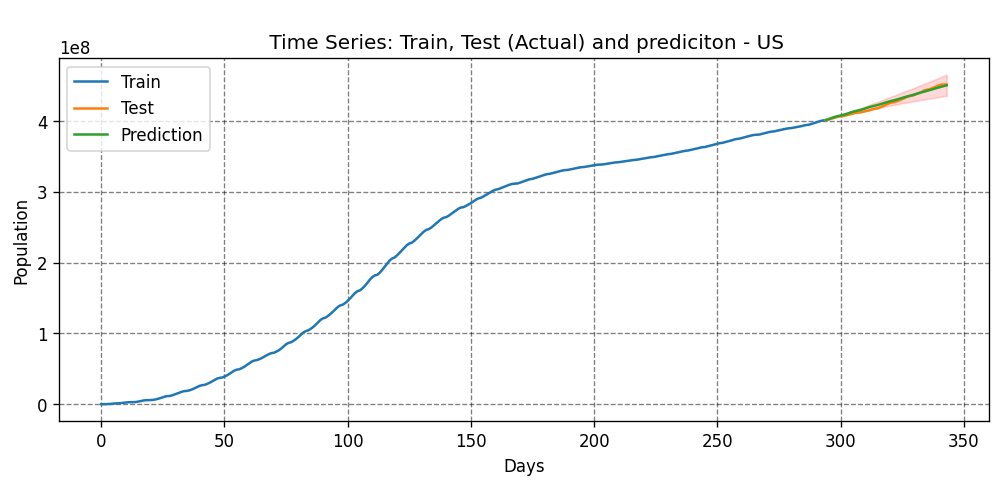

In [111]:
# Training the model using training data and testing the model with testing data - US Dataset
train = val_us[:294]
test = val_us[294:]
steps = 50 
model_US = pm.auto_arima(train,trace=True,error_action='ignore', suppress_warnings=True)
model_US.fit(train)
forecast,confint_ = model_US.predict(n_periods=50,return_conf_int=True,alpha=0.60)
index_of_fc_ = np.arange(len(train), len(train)+steps)

forecast = pd.DataFrame(forecast,index = index_of_fc_,columns=['Prediction'])
test = pd.DataFrame(test,index = index_of_fc_)
lower_series = pd.Series(confint_[:, 0], index=index_of_fc_)
upper_series = pd.Series(confint_[:, 1], index=index_of_fc_)

plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.legend(loc='upper left')
plt.fill_between(lower_series.index,lower_series,upper_series,color='r', alpha=.15)
plt.title("\n Time Series: Train, Test (Actual) and prediciton - US")
plt.xlabel("Days")
plt.ylabel("Population")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.show()

Observation: Even after splitting the dataset, we can see that p,d,q values obtained with the training dataset is the same and the values produced by the forecasting and actual testing values almost overlaps with eachother. This signifies the validity of our model.

# Part 4: Relating COVID-19 to Second Dataset

In [119]:
# Initializing secondary dataset
second_df = main_df_2.copy()
second_df = second_df.drop(second_df[second_df.total_vaccinations.isna()].index)
canada_second_df = second_df[second_df['location']=='Canada']
val = canada_second_df['total_vaccinations'].values

In [120]:
# Checking missing values
canada_second_df.isna().sum()

iso_code                                     0
continent                                    0
location                                     0
date                                         0
total_cases                                  0
                                          ... 
human_development_index                      0
excess_mortality_cumulative_absolute       311
excess_mortality_cumulative                311
excess_mortality                           311
excess_mortality_cumulative_per_million    311
Length: 67, dtype: int64

Lets take a look at correlation of total vaccinations with respect to other fatures.

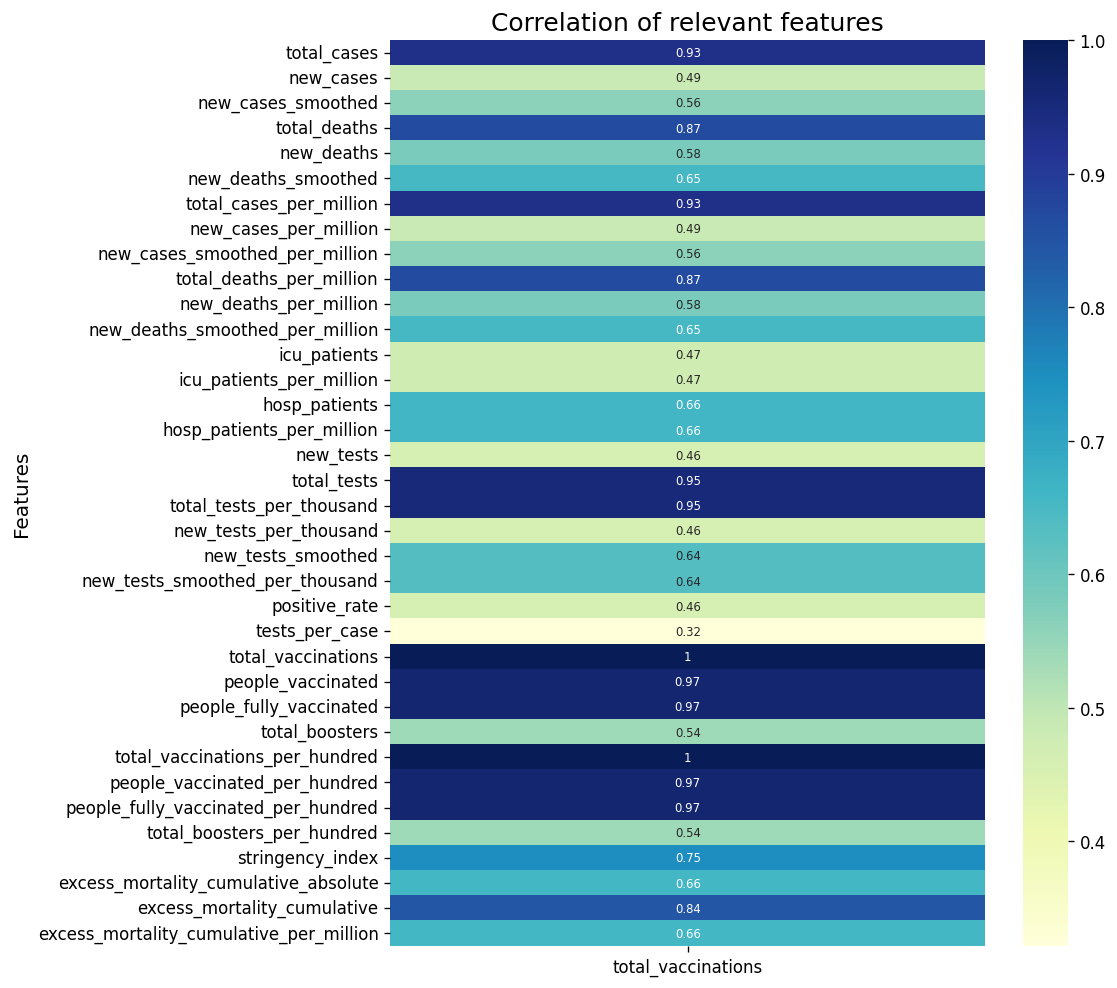

In [134]:
corr = canada_second_df.corr()
corr_df = abs(corr["total_vaccinations"])
# Finding relevant features by filtering our correlation matrix with the feat
relevant_features_vaccine = corr_df[corr_df>0.3] 
relevant_features_vaccine =pd.DataFrame(relevant_features_vaccine)
plt.figure(figsize=(8,10))
sns.heatmap(relevant_features_vaccine, cmap="YlGnBu",annot = True,annot_kws={"size":7}) 
plt.title('Correlation of relevant features' , size = 15) 
#plt.xlabel('Target data', size = 15)
plt.ylabel('Features', size = 12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Observation: From the above plot we can see that irrespective of negative and positive correlation, few plots can make visualization of the dataset better.
We can understand 
* correlation between the total vaccinations and test positive rate. 
* Vaccination effects on the incoming hospital patients because of Covid-19
* Total Vaccinations effect on stringency index in a country
* Effect of number of vaccination on ICU patients
* Total Vaccination and deaths

Similarly the same can be checked for US dataset as well.

In [122]:
US_second_df = second_df[second_df['location']=='United States']
val_us = US_second_df['total_vaccinations'].values

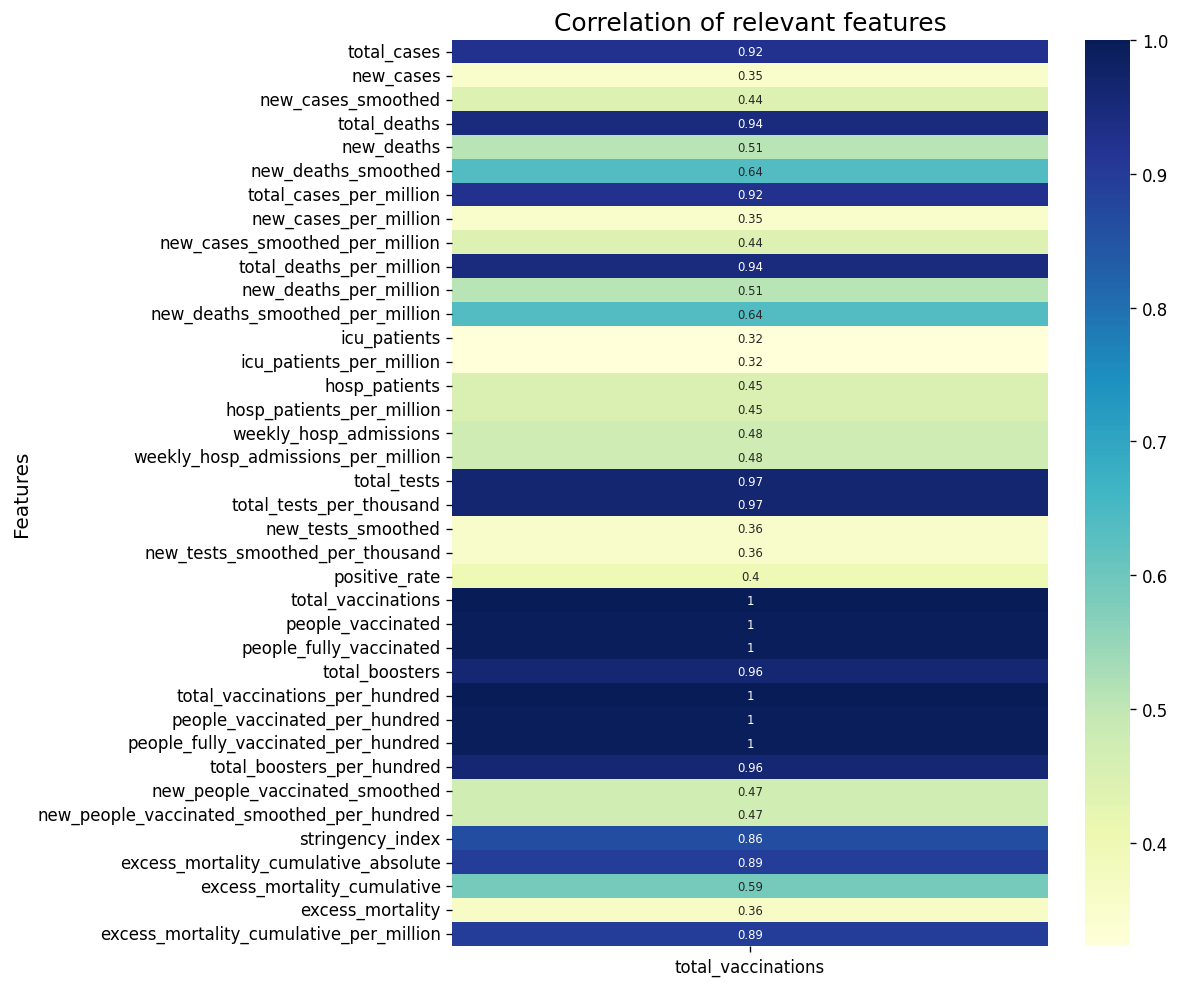

In [123]:
corr = US_second_df.corr()
corr_df = abs(corr["total_vaccinations"])
# Finding relevant features by filtering our correlation matrix with the feat
relevant_features_vaccine = corr_df[corr_df>0.3] 
relevant_features_vaccine =pd.DataFrame(relevant_features_vaccine)
plt.figure(figsize=(8,10))
sns.heatmap(relevant_features_vaccine, cmap="YlGnBu",annot = True,annot_kws={"size":7}) 
plt.title('Correlation of relevant features' , size = 15) 
#plt.xlabel('Target data', size = 15)
plt.ylabel('Features', size = 12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Observation: Apart from the already discussed plots we can also check booster vaccines with respect to total number of vaccines.

In [173]:
print(f"the Date in this time series varies from {list(canada_second_df['date'])[0]} to {list(canada_second_df['date'])[-1]}")

the Date in this time series varies from 2020-12-14 to 2021-11-19


The Second Dataset time series varies from Dec 2020 to Nov 2021. Now lets take a look at the Number of cases trend for both the countries.

Plot1: Cases Trend: Canada and US

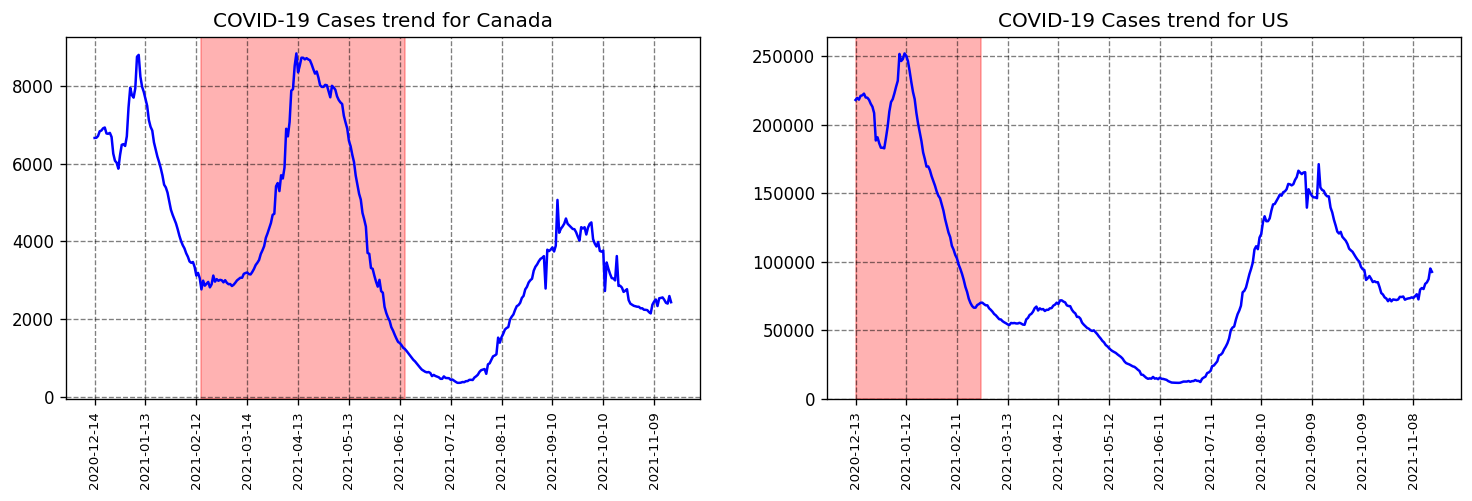

In [202]:
dates_canada_second = list(canada_second_df['date'])
dates_us_second = list(US_second_df['date'])

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,4))
ax1.plot(canada_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'],color = 'blue')
ax1.axvspan(dates_canada_second.index('2021-02-15'), dates_canada_second.index('2021-06-15'), color="red", alpha=0.3)
#ax1.legend(loc='best',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('COVID-19 Cases trend for Canada')
ticks = np.arange(0,341,30)
labels = [dates_canada_second[i]for i in range (0,343,30)]
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, fontsize=8,rotation = 90)
ax1.grid(alpha=0.5, color='k', linestyle='--')

ax2.plot(US_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'],color = 'blue')
#ax2.legend(loc='best',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax2.axvspan(dates_us_second.index('2020-12-13'), dates_us_second.index('2021-02-25'), color="red", alpha=0.3)
ax2.title.set_text('COVID-19 Cases trend for US')
ticks = np.arange(0,341,30)
labels = [dates_us_second[i]for i in range (0,343,30)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, fontsize=8,rotation = 90)
ax2.grid(alpha=0.5, color='k', linestyle='--')

Observation: From the graphs we can understand the COVID 19 case trend for Canada and US. The Highlighted part represents the Start of third wave. For US the start of third was before dec 2020, therefore the ending is represented in the plot.

Plot 2: Vaccination trend with COVID-19 cases: Canada & US



Text(0, 0.5, 'People vaccinated')

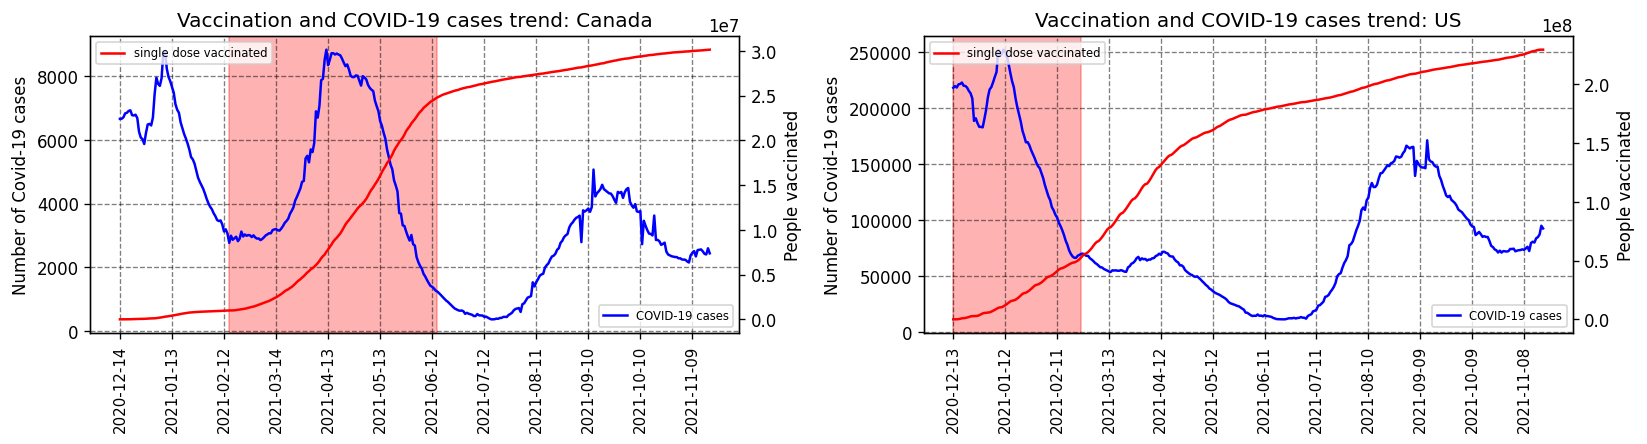

In [233]:
# Lets take a look at the general trend of the number of total cases for US and Canada

dates_canada_second = list(canada_second_df['date'])
dates_us_second = list(US_second_df['date'])

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout(pad=8.0)
ax1.plot(canada_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'],color = 'blue',label='COVID-19 cases')
ax1.axvspan(dates_canada_second.index('2021-02-15'), dates_canada_second.index('2021-06-15'), color="red", alpha=0.3)
ax1.legend(loc='lower right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('Vaccination and COVID-19 cases trend: Canada')
ticks = np.arange(0,341,30)
labels = [dates_canada_second[i]for i in range (0,343,30)]
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, fontsize=9,rotation = 90)
ax1.set_ylabel('Number of Covid-19 cases')
ax1.grid(alpha=0.5, color='k', linestyle='--')
ax3 = ax1.twinx()
ax3.plot(np.arange(0,341), canada_second_df['people_vaccinated'].reset_index()['people_vaccinated'], color='red', label='single dose vaccinated')
#ax3.set_ylim(0, 10000)
ax3.legend(loc='best',prop={"size":7}) 
ax3.set_ylabel('People vaccinated')


ax2.plot(US_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'],color = 'blue',label='COVID-19 cases')
ax2.legend(loc='lower right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax2.axvspan(dates_us_second.index('2020-12-13'), dates_us_second.index('2021-02-25'), color="red", alpha=0.3)
ax2.title.set_text('Vaccination and COVID-19 cases trend: US')
ticks = np.arange(0,341,30)
labels = [dates_us_second[i]for i in range (0,343,30)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, fontsize=9,rotation = 90)
ax2.set_ylabel('Number of Covid-19 cases')
ax2.grid(alpha=0.5, color='k', linestyle='--')
ax4 = ax2.twinx()
ax4.plot(np.arange(0,342), US_second_df['people_vaccinated'].reset_index()['people_vaccinated'], color='red', label='single dose vaccinated')
#ax3.set_ylim(0, 10000)
ax4.legend(loc='best',prop={"size":7}) 
ax4.set_ylabel('People vaccinated')


Observation: From the graph, we can clearly see that during the third wave of COVID-19 on both US and canada, the vaccination rate has been ramped up and thus the number of covid-19 cases begins to drop. And another interesting point to note is that since as the vaccination slope tends to be constant for the cases are begining to increase. Therefore, one may suggest that usage of booster vaccine might become mandatory.

Plot 3: Deaths with respect to vaccination: Canada & US

Text(0, 0.5, 'Number of deaths per day')

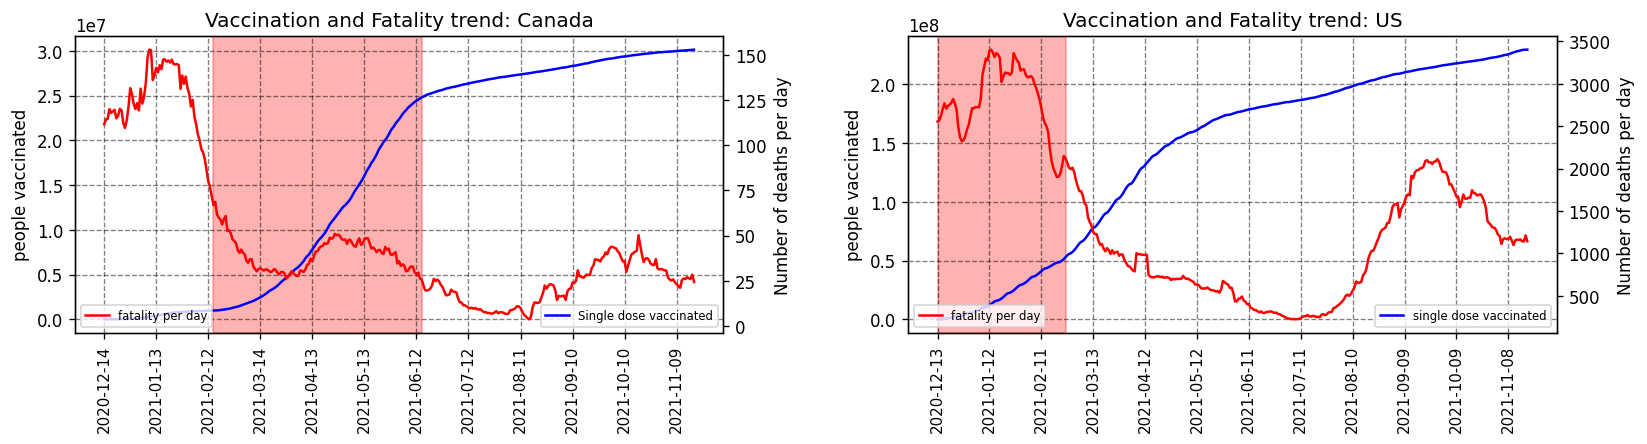

In [255]:
# Lets take a look at the general trend of vaccination and death status for US and Canada

dates_canada_second = list(canada_second_df['date'])
dates_us_second = list(US_second_df['date'])

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout(pad=8.0)
ax1.plot(canada_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='Single dose vaccinated')
ax1.axvspan(dates_canada_second.index('2021-02-15'), dates_canada_second.index('2021-06-15'), color="red", alpha=0.3)
ax1.legend(loc='lower right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('Vaccination and Fatality trend: Canada')
ticks = np.arange(0,341,30)
labels = [dates_canada_second[i]for i in range (0,343,30)]
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, fontsize=9,rotation = 90)
ax1.set_ylabel('people vaccinated')
ax1.grid(alpha=0.5, color='k', linestyle='--')
ax3 = ax1.twinx()
ax3.plot(np.arange(0,341), canada_second_df['new_deaths_smoothed'].reset_index()['new_deaths_smoothed'], color='red', label='fatality per day')
#ax3.set_ylim(0, 10000)
ax3.legend(loc='lower left',prop={"size":7}) 
ax3.set_ylabel('Number of deaths per day')


ax2.plot(US_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='single dose vaccinated')
ax2.legend(loc='lower right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax2.axvspan(dates_us_second.index('2020-12-13'), dates_us_second.index('2021-02-25'), color="red", alpha=0.3)
ax2.title.set_text('Vaccination and Fatality trend: US')
ticks = np.arange(0,341,30)
labels = [dates_us_second[i]for i in range (0,343,30)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, fontsize=9,rotation = 90)
ax2.set_ylabel('people vaccinated')
ax2.grid(alpha=0.5, color='k', linestyle='--')
ax4 = ax2.twinx()
ax4.plot(np.arange(0,342), US_second_df['new_deaths_smoothed'].reset_index()['new_deaths_smoothed'], color='red', label='fatality per day')
#ax3.set_ylim(0, 10000)
ax4.legend(loc='lower left',prop={"size":7}) 
ax4.set_ylabel('Number of deaths per day')

Observation: From the plot, we can observe that in canada the deaths were able to be reduced to a maximum extend becasue of the exponential increase in the vaccination drive as seen in the plot 2. when looking at the US data, we can see that at the third wave, they were not able to effectively vaccinate, therefore we can see that number of deaths were more but as the vaccination increased, the deaths also decreased. But as iterated in the plot 2, as the vaccination drive becomes stagnant the number of deaths is also increasing for US.

Plot 4: Hospital visits, ICU care and vaccination correlation: Canada & US

(0.0, 150000.0)

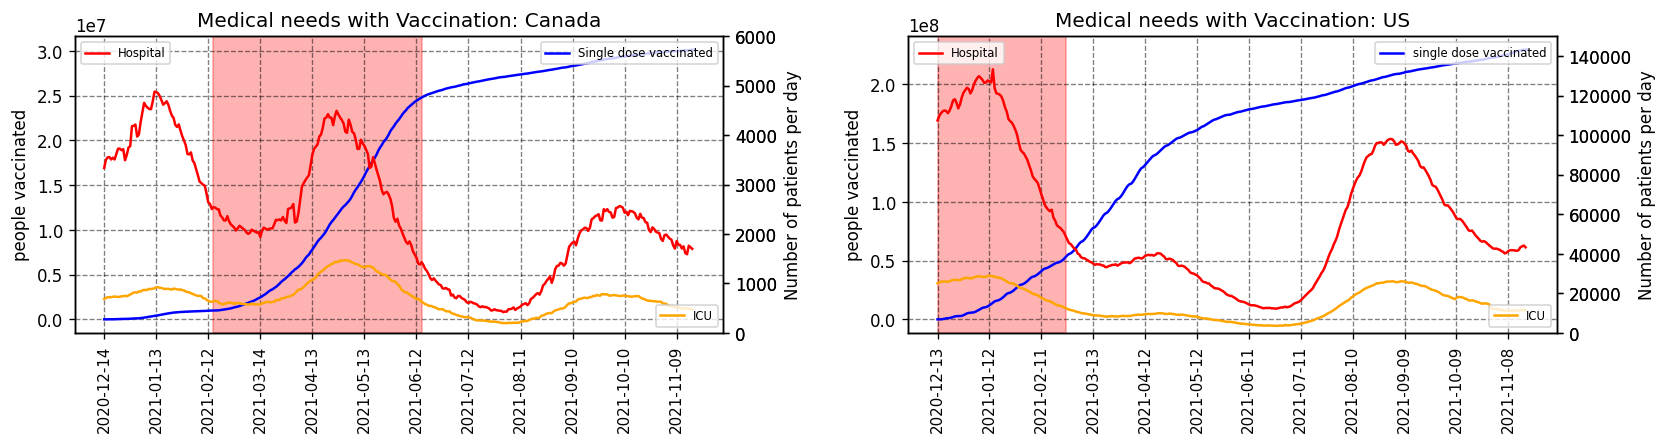

In [299]:
dates_canada_second = list(canada_second_df['date'])
dates_us_second = list(US_second_df['date'])

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout(pad=8.0)
ax1.plot(canada_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='Single dose vaccinated')
ax1.axvspan(dates_canada_second.index('2021-02-15'), dates_canada_second.index('2021-06-15'), color="red", alpha=0.3)
ax1.legend(loc='upper right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('Medical needs with Vaccination: Canada')
ticks = np.arange(0,341,30)
labels = [dates_canada_second[i]for i in range (0,343,30)]
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, fontsize=9,rotation = 90)
ax1.set_ylabel('people vaccinated')
ax1.grid(alpha=0.5, color='k', linestyle='--')
ax3 = ax1.twinx()
ax3.plot(np.arange(0,341), canada_second_df['hosp_patients'].reset_index()['hosp_patients'], color='red', label='Hospital')
ax3.legend(loc='upper left',prop={"size":7}) 
ax3.set_ylabel('Number of patients per day')
ax3.set_ylim(0, 6000)
ax5 = ax1.twinx()
ax5.plot(np.arange(0,341), canada_second_df['icu_patients'].reset_index()['icu_patients'], color='orange', label='ICU')
ax5.legend(loc='lower right',prop={"size":7}) 
ax5.set_ylim(0, 6000)


ax2.plot(US_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='single dose vaccinated')
ax2.legend(loc='upper right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax2.axvspan(dates_us_second.index('2020-12-13'), dates_us_second.index('2021-02-25'), color="red", alpha=0.3)
ax2.title.set_text('Medical needs with Vaccination: US')
ticks = np.arange(0,341,30)
labels = [dates_us_second[i]for i in range (0,343,30)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, fontsize=9,rotation = 90)
ax2.set_ylabel('people vaccinated')
ax2.grid(alpha=0.5, color='k', linestyle='--')
ax4 = ax2.twinx()
ax4.plot(np.arange(0,342), US_second_df['hosp_patients'].reset_index()['hosp_patients'], color='red', label='Hospital')
#ax3.set_ylim(0, 10000)
ax4.legend(loc='upper left',prop={"size":7}) 
ax4.set_ylabel('Number of patients per day')
ax4.set_ylim(0, 150000)
ax6 = ax2.twinx()
ax6.plot(np.arange(0,342), US_second_df['icu_patients'].reset_index()['icu_patients'], color='orange', label='ICU')
ax6.legend(loc='lower right',prop={"size":7}) 
ax6.set_ylim(0, 150000)

Observation: from the plots it can be seen that Medical needs of the people are high at the third wave of corono virus. However as the vaccination rate was very high the medical needs were supressed. But as the vaccination becomes stagnant and new variant of corona virus starts to spread the need for hospital/ICU care is also increasing.

Plot5: Stringency Index with vaccination and COVID Cases: Canada & US

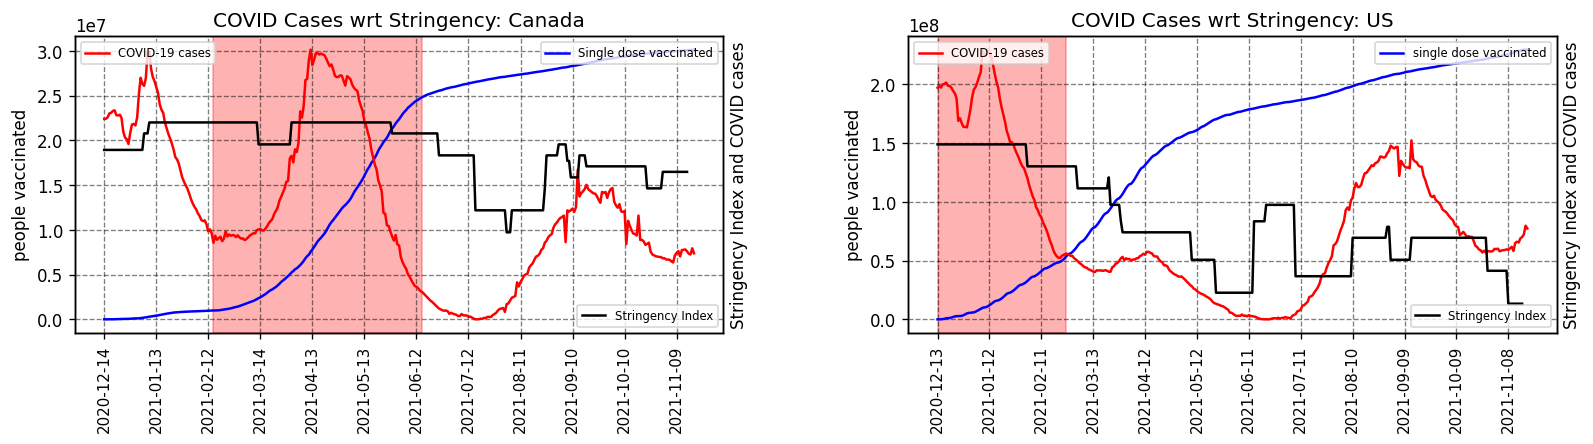

In [268]:
dates_canada_second = list(canada_second_df['date'])
dates_us_second = list(US_second_df['date'])

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.tight_layout(pad=8.0)
ax1.plot(canada_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='Single dose vaccinated')
ax1.axvspan(dates_canada_second.index('2021-02-15'), dates_canada_second.index('2021-06-15'), color="red", alpha=0.3)
ax1.legend(loc='upper right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.title.set_text('COVID Cases wrt Stringency: Canada')
ticks = np.arange(0,341,30)
labels = [dates_canada_second[i]for i in range (0,343,30)]
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels, fontsize=9,rotation = 90)
ax1.set_ylabel('people vaccinated')
ax1.grid(alpha=0.5, color='k', linestyle='--')
ax3 = ax1.twinx()
ax3.plot(np.arange(0,341), canada_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'], color='red', label='COVID-19 cases')
ax3.legend(loc='upper left',prop={"size":7}) 
ax3.set_ylabel('Stringency Index and COVID cases')
ax3.yaxis.set_major_locator(plt.NullLocator())
#ax3.set_ylim(0, 6000)
ax5 = ax1.twinx()
ax5.plot(np.arange(0,341), canada_second_df['stringency_index'].reset_index()['stringency_index'], color='black', label='Stringency Index')
ax5.legend(loc='lower right',prop={"size":7}) 
ax5.set_ylim(40, 90)
ax5.yaxis.set_major_locator(plt.NullLocator())


ax2.plot(US_second_df['people_vaccinated'].reset_index()['people_vaccinated'],color = 'blue',label='single dose vaccinated')
ax2.legend(loc='upper right',prop={"size":7})
#ax1.xaxis.set_major_locator(plt.NullLocator())
ax2.axvspan(dates_us_second.index('2020-12-13'), dates_us_second.index('2021-02-25'), color="red", alpha=0.3)
ax2.title.set_text('COVID Cases wrt Stringency: US')
ticks = np.arange(0,341,30)
labels = [dates_us_second[i]for i in range (0,343,30)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels, fontsize=9,rotation = 90)
ax2.set_ylabel('people vaccinated')
ax2.grid(alpha=0.5, color='k', linestyle='--')
ax4 = ax2.twinx()
ax4.plot(np.arange(0,342), US_second_df['new_cases_smoothed'].reset_index()['new_cases_smoothed'], color='red', label='COVID-19 cases')
#ax3.set_ylim(0, 10000)
ax4.legend(loc='upper left',prop={"size":7}) 
ax4.set_ylabel('Stringency Index and COVID cases')
ax4.yaxis.set_major_locator(plt.NullLocator())
ax6 = ax2.twinx()
ax6.plot(np.arange(0,342), US_second_df['stringency_index'].reset_index()['stringency_index'], color='black', label='Stringency Index')
ax6.legend(loc='lower right',prop={"size":7}) 
ax6.set_ylim(40, 90)
ax6.yaxis.set_major_locator(plt.NullLocator())

Observation: From the graph we can observe that, for both the countries, as the stringency index is decreased to all time low at july/August, the covid cases seems to increase aprubtly with covid vaccination becoming stagnent. But if the COVID vaccination increased along with leniency in stringency index, then probably there would not be a greater heap of increase in the covid-19 cases.

In [269]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Since we need to know mainly about the requirement of people in need of ICU/ hospital needs, lets take that as y value and correlated features such as covid cases, stringency index and few other columns as input feature and develop a simple linear regression model.

Mean squared error: 100278.73
Coefficient of determination: 0.93


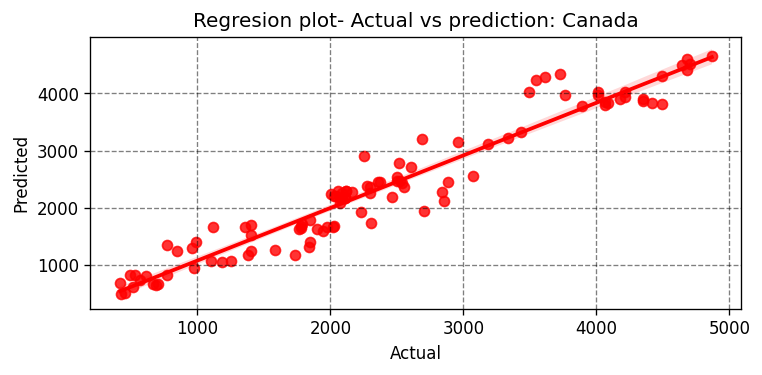

In [306]:
# Medical needs: Prediciton and actual values 
X = canada_second_df[['new_tests_smoothed','positive_rate','new_cases_smoothed','stringency_index','new_deaths_smoothed']]
X.new_tests_smoothed.fillna(0, inplace = True)
X.positive_rate.fillna(0, inplace = True)
X.new_cases_smoothed.fillna(0, inplace = True)
X.stringency_index.fillna(0, inplace = True)
X.new_deaths_smoothed.fillna(0, inplace = True)
Y = canada_second_df[['hosp_patients']]
Y.hosp_patients.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=44)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

plt.figure(figsize=(7,3))
sns.regplot(x=y_test,y=y_pred, color='red')
plt.title("Regresion plot- Actual vs prediction: Canada")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Observation: We were able to build a model based on the new test data, positivity rate, new cases, stringency index in country and new deaths with cooefficent of determination of 0.93. Inorder to know the actual needs of the hospital/ICU needs, we can interpolate the data and get the result for the same. However this model is simple and more complex model needs to be implemented for further actual usage.

Mean squared error: 42379454.25
Coefficient of determination: 0.96


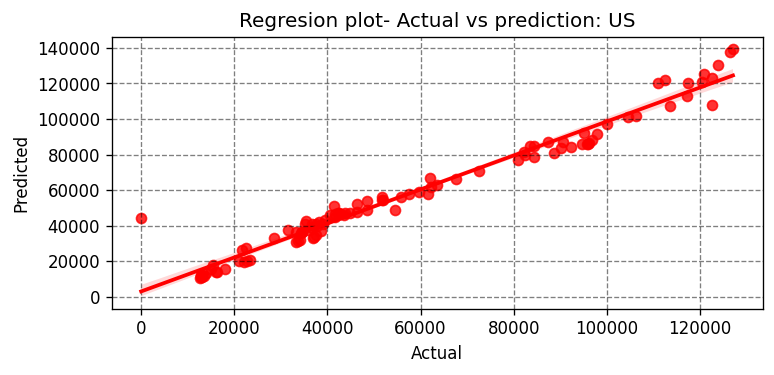

In [307]:
# Medical needs: Prediciton and actual values 
X = US_second_df[['new_tests_smoothed','positive_rate','new_cases_smoothed','stringency_index','new_deaths_smoothed']]
X.new_tests_smoothed.fillna(0, inplace = True)
X.positive_rate.fillna(0, inplace = True)
X.new_cases_smoothed.fillna(0, inplace = True)
X.stringency_index.fillna(0, inplace = True)
X.new_deaths_smoothed.fillna(0, inplace = True)
Y = US_second_df[['hosp_patients']]
Y.hosp_patients.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=44)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

plt.figure(figsize=(7,3))
sns.regplot(x=y_test,y=y_pred, color='red')
plt.title("Regresion plot- Actual vs prediction: US")
plt.grid(alpha=0.5, color='k', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Observation: As suggested in the previous plot, we were able to obtain a satisfactory model for prediction. But more complex model needs to be made in order to use in real life. However extraplolation can give necessary details of hospital needs as per the current daily covid case increase and stringency index of the country.

# Part 5: Effect of Vaccination Discussion:

In lieu of COVID-19, Vaccination has been one of the major driver for restricting the spread of virus. Usually when there is a **new variant** there seems to be a **hike in the spread of virus** and thus resulting in hospitalization and increase fatality, as seen in the part 4, first plot: COVID cases trend (with third wave highlighted) where the delta variant spread more. 

In part 3, with the help of ARIMA model, the prediciton of the base case, best case and worst case senario was predicted for Canada and US, the base case seems to be almost stagnant with current rate. but with the increase in the new omicorn variant, it would be better to implement more vaccination to citizens. so as to control the growth rate or flatten the curve. 

Also, it is necessary to note that, Stringency index i.e., country's rules and statements for safe precedings during covid time also plays a vital role in managind the spred of COVID-19. In part 4 from plot 5 we can see that as US and Canada extended lineance to the public, there seems to be rapid increase in the covid spread, however, the vaccination rate was very low compared to previous months when stringency index was low. If the strengency index was low and vaccination rate was also high it would have made a difference. 

Also, it is to be noted that as per plot 5 in part 4, for US with almost flat vaccination rate, and lowering strengency, may lead to another huge lead in the covid surge in the country. 

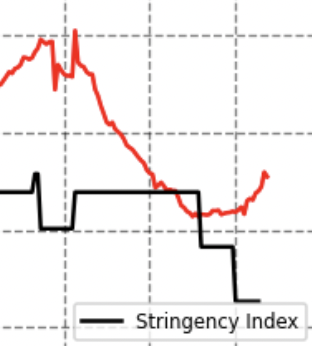





From the screenshot above we can see that there is already a surge in the covid virus spread. Therefore vaccination / Booster vaccination needs to be increased.

EFFECTIVE VACCINATION PROGRAM:

Effective vaccination program is analysed on part 2, based on the country's capacity to administer vaccines to number of people out of 100 people based population of that specific country. In part 2 EDA, the plot named "*Top ten countries with effective vaccination program*" we can see that UAE, Singapore, cuba are some of the countries which effectively administered vaccines to its population. However it was really  a huge acheivement for China as its the biggest populus contry and was able to administer vaccine effectively. Their program must be one of the most effective ways to take vaccines to the masses. 

When comparing US and Canada, it can be noted that from plot 2 of the part 4, we can see that during the third wave of Covid spread, Canada was able to administer vaccine to most of its population, but whereas US was rolling out vaccination gradually and has started to vaccinate more after thrid wave ended, which is not a wise vaccination program.